In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [4]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_around_onset_combined_dhpc'

In [12]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

 Unable to restore variable 'do_test_cross', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_cross_distinct', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_within', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_within_subsets', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)


In [6]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [7]:
all_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
expo_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
pre_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36', #,'dhpcg20' #dHPC20 performed very well on day 1 (d' = 2)
d2_animals =  'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
post_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
renew_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
ext2_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
ext1_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'

In [8]:
sessions = 'expo', 'pre', 'd2', 'post', 'ext1', 'ext2', 'renew'

In [10]:
for sess in 'pre', 'd2', 'post', 'ext1', 'ext2', 'renew':

    exec("patterns_tb_%s = dict(zip(%s_animals, [ut.load_variable('patterns_tb',\
                                                           '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))
    exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels',\
                                                         '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))

In [11]:
#have to extract 2_odor_expo varibles differently from that used above
patterns_tb_expo = dict(zip(expo_animals,
                                [ut.load_variable('patterns_tb','../%s/2_odor_expo/notebooks/autorestore/decoding_around_onset'%ani)
                                                  for ani in expo_animals]))

labels_expo = dict(zip(expo_animals,
                                [ut.load_variable('labels','../%s/2_odor_expo/notebooks/autorestore/decoding_around_onset'%ani)
                                                  for ani in expo_animals]))

In [53]:
dark_co = ('forestgreen','darkcyan','rebeccapurple','firebrick','lightgrey','dimgrey','goldenrod')
alt_co = ('hotpink','mediumorchid','darkturquoise','mediumspringgreen','lawngreen','khaki')
session_labels = ('Pre','Early','Day2','Late','Ext1','Ext2','Reinstate')

In [12]:
#delta_t0 = 1
#
#t_start0 = -5  # sec
#t_stop0 = 11  # sec

In [13]:
#for sess in ['pre']:
#    exec("labels_tb_%s = {}"%sess)
#    for ani in eval('%s_animals'%sess):
#        exec("labels_tb_%s[%s] = np.r_[[[l]*patterns_tb_%s[%s].shape[0] for l in labels_%s[%s]]].T"%(sess,ani,sess,ani,sess,ani))

In [14]:
#labels_tb_pre = {}
#
#labels_tb_pre['c3f3'] = np.r_[[[l]*patterns_tb_pre['c3f3'].shape[0] for l in labels_pre['c3f3']]].T

In [15]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within(patterns, labels, n_cells=None):
    
    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_train_a = np.random.permutation(np.where(labels[ani]==0)[0])
        which_test_a = which_train_a[:len(which_train_a)/2]
        which_train_a = which_train_a[len(which_train_a)/2:]
        
        which_train_b = np.random.permutation(np.where(labels[ani]==1)[0])
        which_test_b = which_train_b[:len(which_train_b)/2]
        which_train_b = which_train_b[len(which_train_b)/2:]
        
        which_train[ani] = np.concatenate((which_train_a, which_train_b))
        which_test[ani] = np.concatenate((which_test_a, which_test_b))
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    patterns_T = patterns.copy()
    labels_T = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
        patterns_T[ani] = patterns[ani][which_test[ani]]
        labels_T[ani] = labels[ani][which_test[ani]]
    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_t, labels_t)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_T, labels_T)
    
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
        
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    scores = decoder.score(patterns_comb_test[:, cells], labels_comb)
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb))

In [16]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [17]:
#[[[trial for trial in patterns_tb_pre[ani]] for ani in pre_animals]].shape
##trial[trial number][cell#] for blah in pre_animals[animal number]

In [18]:
for sess in sessions:
    for t in range(0,16):
        exec('patterns_tb_%s_%s = {}'%(t, sess))
        for ani in eval('%s_animals'%sess):
            try:
                print sess,
                print ani,
                exec("patterns_tb_%s_%s['%s'] = patterns_tb_%s['%s'][%s]"%(t,sess,ani,sess,ani,t))
            except IOError as error:
                print error
            continue

expo dhpcg1 expo dhpc24 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpc35 expo dhpc36 expo dhpcg20 pre dhpcg1 pre dhpc24 pr

In [19]:
%%time
for t in range(0,16): # number of time bins
    exec('scores_tb_%s = {}'%t)
    n_loops = 30
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s"%t)[sess] = np.r_[[do_test_within(eval('patterns_tb_%s_%s'%(t,sess)),eval('labels_%s'%sess)) for i in range(n_loops)]]

expo 0 pre 0 d2 0 post 0 ext1 0 ext2 0 renew 0 expo 1 pre 1 d2 1 post 1 ext1 1 ext2 1 renew 1 expo 2 pre 2 d2 2 post 2 ext1 2 ext2 2 renew 2 expo 3 pre 3 d2 3 post 3 ext1 3 ext2 3 renew 3 expo 4 pre 4 d2 4 post 4 ext1 4 ext2 4 renew 4 expo 5 pre 5 d2 5 post 5 ext1 5 ext2 5 renew 5 expo 6 pre 6 d2 6 post 6 ext1 6 ext2 6 renew 6 expo 7 pre 7 d2 7 post 7 ext1 7 ext2 7 renew 7 expo 8 pre 8 d2 8 post 8 ext1 8 ext2 8 renew 8 expo 9 pre 9 d2 9 post 9 ext1 9 ext2 9 renew 9 expo 10 pre 10 d2 10 post 10 ext1 10 ext2 10 renew 10 expo 11 pre 11 d2 11 post 11 ext1 11 ext2 11 renew 11 expo 12 pre 12 d2 12 post 12 ext1 12 ext2 12 renew 12 expo 13 pre 13 d2 13 post 13 ext1 13 ext2 13 renew 13 expo 14 pre 14 d2 14 post 14 ext1 14 ext2 14 renew 14 expo 15 pre 15 d2 15 post 15 ext1 15 ext2 15 renew 15CPU times: user 4min 54s, sys: 864 ms, total: 4min 55s
Wall time: 4min 54s



In [140]:
def do_test_within_w_n_cells(patterns, labels, ncells=None, n_loops=10, cellreg=False, n_steps=15, **args):
    
    #scores = np.r_[[do_test_within(patterns, labels, **args) for i in range(n_loops)]]
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in patterns.keys()])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], n_loops)
        
    scores_ncells = np.r_[[do_test_within_b(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    #return scores, ncells, scores_ncells
    return ncells, scores_ncells

from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns_b(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):
#     which_train = range(90)
#     which_test = range(90)

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if relabel_test is not None:
        labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
    else:
        if relabel is not None:
            labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
        else:
            labels_comb_test = labels_comb_test_
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test

    return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
            patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
        
def do_test_within_b(patterns, labels, **args):
    x, y, xT, yT = combine_train_test_patterns_b(patterns, labels, **args)
    #decoder.fit(x, y)
    #return decoder.score(xT, yT)
    decoder.fit(x,y)
    scores = decoder.score(xT, yT)
    decoder.fit(xT,yT)
    return np.append(scores, decoder.score(x, y))

def plot_scores_compare2(score1, score2, colors=['b', 'r',], labels=True, chance=None, ax=None, tick_lab=['pre','post']):
    if ax is None:
        fig, ax = pl.subplots(1, 1, figsize=(1, 2))
    values = [score1*100, score2*100]
    pt.plot_bars(values, ax=ax, colors=colors, stderr=False)
    if chance is not None:
        ax.hlines(chance, -0.5, 2-0.5, linestyles='dashed')

    ax.set_xticks(range(2))
    ax.set_xticklabels(tick_lab, rotation=30)
    
    ax.set_ylim(40,100)

    if labels:
        ax.set_ylabel('Decoding Performance (%)')
    pvs = []
    pvs.append(pt.add_significance(ax, values[0], values[1], 0, 1, 104)) #will compare sessions 'x' in values[x]
    
    return ax

def plot_scores_vs_ncells(ncells, scores, labels=True, dots=False, dot_color=(1, 0.7, 0.7), color='r', chance=None, ax=None):
    if ax is None:
        fig, ax = pl.subplots(1, 1, figsize=(1, 1))
    if dots == True:
        ax.plot(ncells, scores*100, 'o', ms=2, mew=0, color=dot_color, zorder=0)
    m = scores.reshape(-1, n_loops).mean(1)*100
    s = np.std(scores.reshape(-1, n_loops), 1)*100
    n = ncells[::n_loops]
    ax.plot(n, m, color=color)
    ax.fill_between(n,m-s,m+s,alpha=0.2,color=color,linewidth=0)
    #ax.errorbar(ncells[::n_loops], scores.reshape(-1, n_loops).mean(1)*100,
    #            np.std(scores.reshape(-1, n_loops), 1)*100,color=color)
    ax.set_ylim(40, 100)
    
    if labels:
        ax.set_xlabel("No. of Cells")
        ax.set_ylabel("Performance")

    if chance is not None:
        xmin, xmax, _, _  = ax.axis()
        ax.hlines(chance, -20, xmax-20, linestyles='dashed', lw=0.5, color='k')

    return ax

In [153]:
scores_tb_6_ncells['pre'].mean(1)

array([ 0.5875,  0.5925,  0.515 , ...,  0.94  ,  0.955 ,  0.9375])

In [149]:
scores_gmin_tb_6['pre'].shape

(30, 2)

In [ ]:
#%%time
#for t in range(16): # number of time bins
#    exec('n_scores_tb_%s = {}'%t)
#    exec('scores_tb_%s_ncells = {}'%t)
#    exec('n_cells_%s = {}'%t)
#    n_loops=200
#    for sess in sessions:
#        print sess,
#        print t,
#        eval("n_cells_%s"%t)[sess],eval("scores_tb_%s_ncells"%t)[sess] = do_test_within_w_n_cells(eval('patterns_tb_%s_%s'%(t,sess)),
#                                                eval('labels_%s'%sess),n_loops=n_loops)

In [147]:
n_loops

200

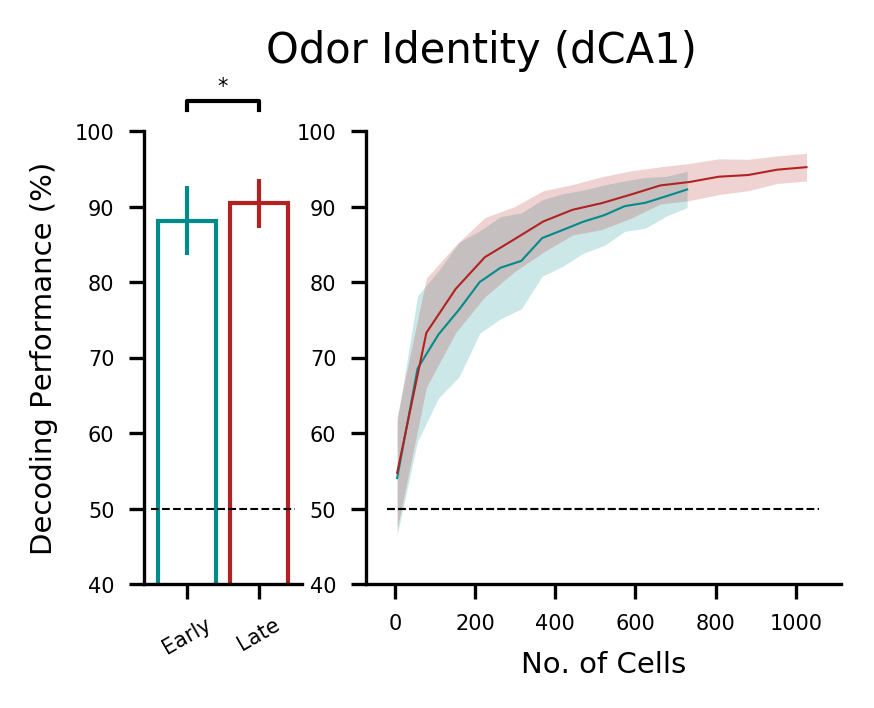

In [145]:
fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2(scores_gmin_tb_6['pre'][:n_loops].mean(1), scores_gmin_tb_6['post'][:n_loops].mean(1), chance=50,
                     ax=axs[0], colors=[dark_co[1],dark_co[3]],tick_lab=['Early','Late'])

plot_scores_vs_ncells(n_cells_6['pre'], scores_tb_6_ncells['pre'].mean(1), dot_color=(0.7, 0.7, 1), color=dark_co[1], chance=50, 
                      ax=axs[1], labels=False,dots=False)
plot_scores_vs_ncells(n_cells_6['post'], scores_tb_6_ncells['post'].mean(1), color=dark_co[3],chance=50,
                      ax=axs[1], labels=False,dots=False)

axs[1].set_xlabel("No. of Cells")

fig.suptitle("Odor Identity (dCA1)", fontsize=10, y=1.05)

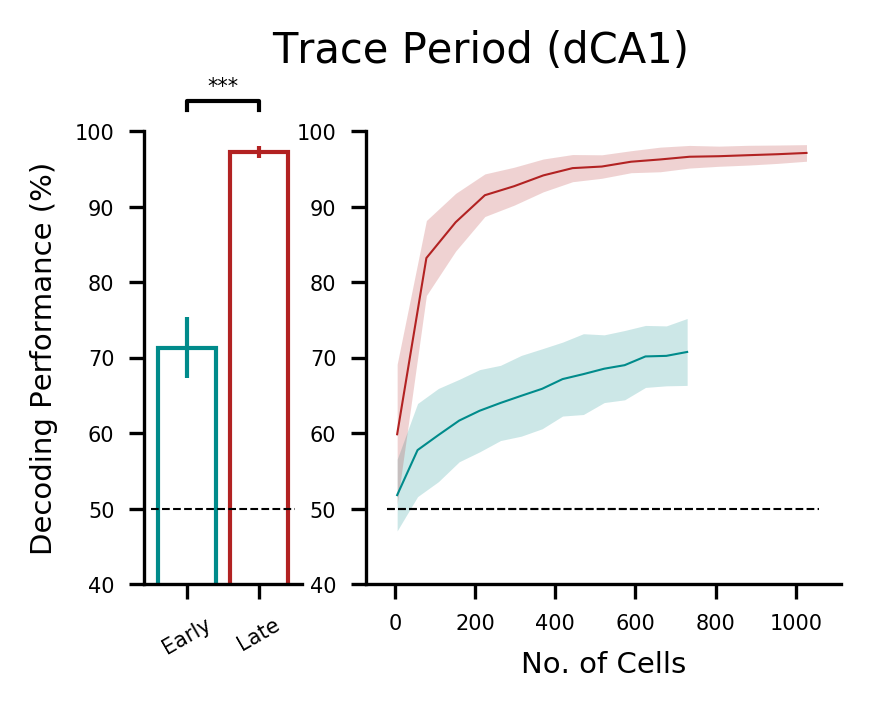

In [142]:
fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2(scores_tb_8['pre'][:n_loops].mean(1), scores_tb_8['post'][:n_loops].mean(1), chance=50, ax=axs[0],
                     colors=[dark_co[1],dark_co[3]],tick_lab=['Early','Late'])

plot_scores_vs_ncells(n_cells_8['pre'], scores_tb_8_ncells['pre'].mean(1), dot_color=(0.7, 0.7, 1), color=dark_co[1], chance=50, 
                      ax=axs[1], labels=False,dots=False)
plot_scores_vs_ncells(n_cells_8['post'], scores_tb_8_ncells['post'].mean(1), color=dark_co[3],chance=50,
                      ax=axs[1], labels=False,dots=False)

axs[1].set_xlabel("No. of Cells")

fig.suptitle("Trace Period (dCA1)", fontsize=10,y=1.05)

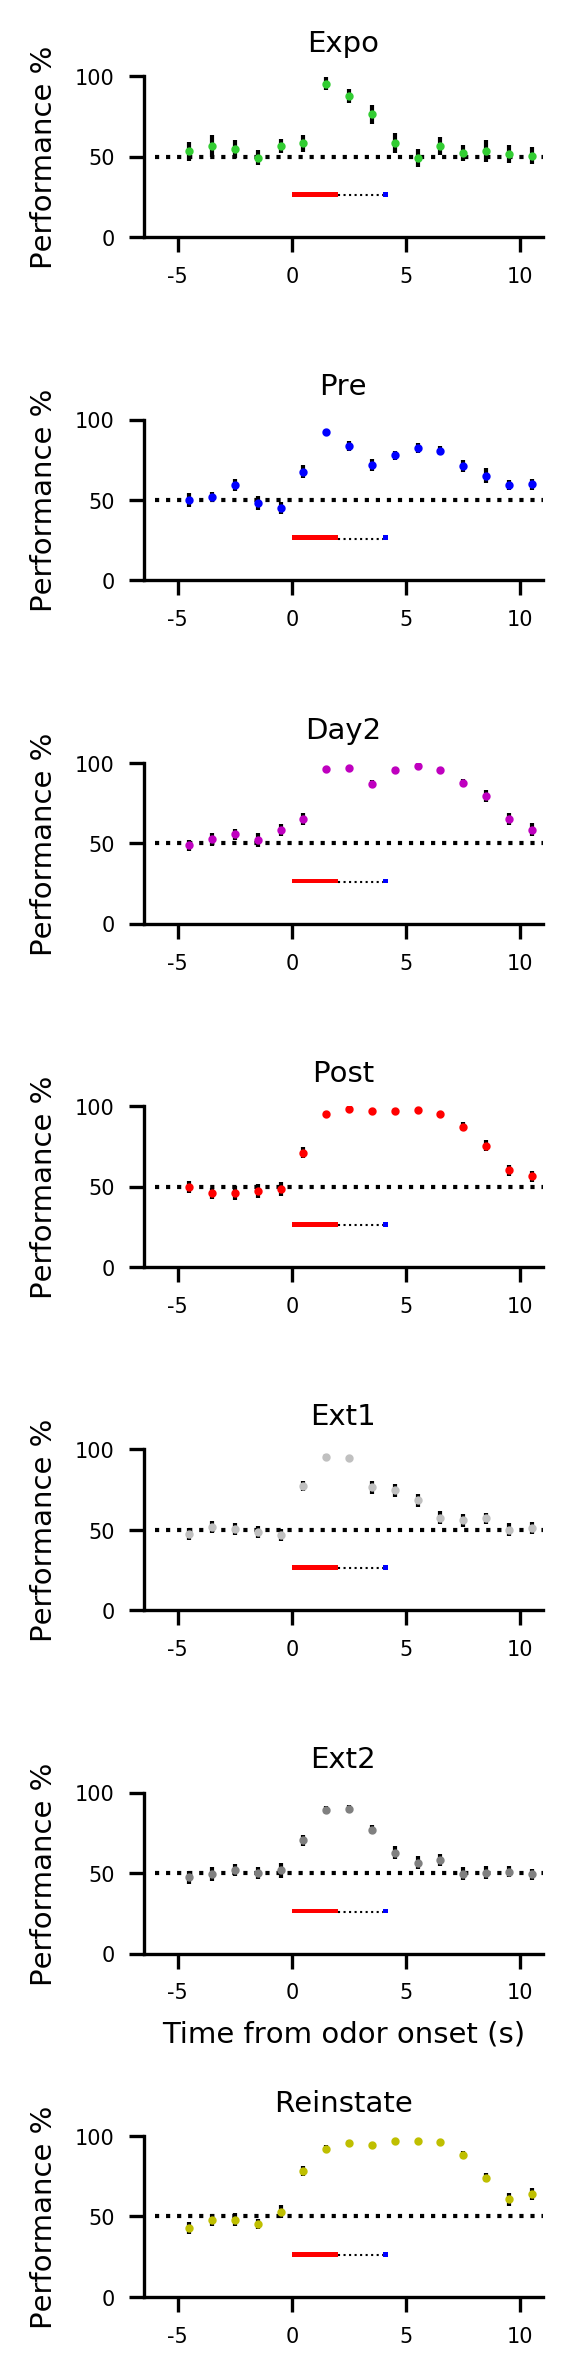

In [20]:
fig, ax = pl.subplots(7,1, figsize=(2, 8))

#t = np.arange(t_start0, t_stop0, delta_t0)
# ax.fill_between(t+np.diff(t)[0]/2.,
#                 (scores.mean(1) + np.std(scores, 1))*100,
#                 (scores.mean(1) - np.std(scores, 1))*100,
#                 lw=0, color='0.8')
for t in range(0,16):
    ax[0].plot(t-4.5, np.mean(eval("scores_tb_%s['expo']"%t))*100, 'o', color='limegreen', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s['expo']"%t))*100
    s = np.std(eval("scores_tb_%s['expo']"%t))*100 / np.sqrt(eval("scores_tb_%s['expo']"%t).shape[-1])
    ax[0].errorbar(t-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[1].plot(t-4.5, np.mean(eval("scores_tb_%s['pre']"%t))*100, 'o', color='blue', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s['pre']"%t))*100
    s = np.std(eval("scores_tb_%s['pre']"%t))*100 / np.sqrt(eval("scores_tb_%s['pre']"%t).shape[-1])
    ax[1].errorbar(t-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[2].plot(t-4.5, np.mean(eval("scores_tb_%s['d2']"%t))*100, 'o', color='m', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s['d2']"%t))*100
    s = np.std(eval("scores_tb_%s['d2']"%t))*100 / np.sqrt(eval("scores_tb_%s['d2']"%t).shape[-1])
    ax[2].errorbar(t-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[3].plot(t-4.5, np.mean(eval("scores_tb_%s['post']"%t))*100, 'o', color='red', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s['post']"%t))*100
    s = np.std(eval("scores_tb_%s['post']"%t))*100 / np.sqrt(eval("scores_tb_%s['post']"%t).shape[-1])
    ax[3].errorbar(t-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[4].plot(t-4.5, np.mean(eval("scores_tb_%s['ext1']"%t))*100, 'o', color='silver', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s['ext1']"%t))*100
    s = np.std(eval("scores_tb_%s['ext1']"%t))*100 / np.sqrt(eval("scores_tb_%s['ext1']"%t).shape[-1])
    ax[4].errorbar(t-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[5].plot(t-4.5, np.mean(eval("scores_tb_%s['ext2']"%t))*100, 'o', color='grey', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s['ext2']"%t))*100
    s = np.std(eval("scores_tb_%s['ext2']"%t))*100 / np.sqrt(eval("scores_tb_%s['ext2']"%t).shape[-1])
    ax[5].errorbar(t-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[6].plot(t-4.5, np.mean(eval("scores_tb_%s['renew']"%t))*100, 'o', color='y', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s['renew']"%t))*100
    s = np.std(eval("scores_tb_%s['renew']"%t))*100 / np.sqrt(eval("scores_tb_%s['renew']"%t).shape[-1])
    ax[6].errorbar(t-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
for x in range (0,7):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-6.5, 11)
    ax[x].set_xticks(np.arange(-5,11, 5))
    ax[x].set_xticklabels(np.arange(-5,11, 5))
    ax[x].hlines(50, -6,11, color='k', lw=1, linestyles='dotted')
    ax[5].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Expo')
ax[1].set_title('Pre')
ax[2].set_title('Day2')
ax[3].set_title('Post')
ax[4].set_title('Ext1')
ax[5].set_title('Ext2')
ax[6].set_title('Reinstate')
fig.tight_layout(pad=2)


fig.savefig('../img/%s.jpg'%NOTEBOOK_NAME)

# Now for equalizing cell #s across all sess by using global min

In [21]:
#get number of vHPC cells used for decoding
cell_total = ['total_cells_expo', 'total_cells_pre', 'total_cells_post','total_cells_ext1','total_cells_ext2','total_cells_renew']
for tot in cell_total:
    what = ut.load_variable('%s'%(tot), '../notebooks/autorestore/decoding_combined_vhpc/')
    exec('%s_vHPC = what'%(tot))
    print '%s_vHPC ='%(tot),
    print what

total_cells_expo_vHPC = 563
total_cells_pre_vHPC = 521
total_cells_post_vHPC = 454
total_cells_ext1_vHPC = 475
total_cells_ext2_vHPC = 518
total_cells_renew_vHPC = 473


In [22]:
#get number of vdPC cells used for decoding
cell_total = ['total_cells_expo', 'total_cells_pre', 'total_cells_post','total_cells_ext1','total_cells_ext2','total_cells_renew']
for tot in cell_total:
    what = ut.load_variable('%s'%(tot), '../notebooks/autorestore/decoding_combined_dhpc/')
    exec('%s_dHPC = what'%(tot))
    print '%s_dHPC ='%(tot),
    print what

total_cells_expo_dHPC = 732
total_cells_pre_dHPC = 578
total_cells_post_dHPC = 842
total_cells_ext1_dHPC = 714
total_cells_ext2_dHPC = 759
total_cells_renew_dHPC = 668


In [23]:
n_cells = np.min((total_cells_pre_vHPC,total_cells_pre_dHPC, total_cells_post_vHPC,total_cells_post_dHPC,
                total_cells_ext1_vHPC,total_cells_ext1_dHPC, total_cells_ext2_vHPC,total_cells_ext2_dHPC,
                total_cells_renew_vHPC,total_cells_renew_dHPC, total_cells_expo_vHPC,total_cells_expo_dHPC))
gmin = np.min((total_cells_pre_vHPC,total_cells_pre_dHPC, total_cells_post_vHPC,total_cells_post_dHPC,
                total_cells_ext1_vHPC,total_cells_ext1_dHPC, total_cells_ext2_vHPC,total_cells_ext2_dHPC,
                total_cells_renew_vHPC,total_cells_renew_dHPC, total_cells_expo_vHPC,total_cells_expo_dHPC))

In [24]:
%%time
for t in range(0,16): # number of time bins
    exec('scores_gmin_tb_%s = {}'%t)
    n_loops = 30
    for sess in sessions:
        print sess,
        print t,
        eval("scores_gmin_tb_%s"%t)[sess] = np.r_[[do_test_within(eval('patterns_tb_%s_%s'%(t,sess)),eval('labels_%s'%sess),n_cells=gmin) for i in range(n_loops)]]

expo 0 pre 0 d2 0 post 0 ext1 0 ext2 0 renew 0 expo 1 pre 1 d2 1 post 1 ext1 1 ext2 1 renew 1 expo 2 pre 2 d2 2 post 2 ext1 2 ext2 2 renew 2 expo 3 pre 3 d2 3 post 3 ext1 3 ext2 3 renew 3 expo 4 pre 4 d2 4 post 4 ext1 4 ext2 4 renew 4 expo 5 pre 5 d2 5 post 5 ext1 5 ext2 5 renew 5 expo 6 pre 6 d2 6 post 6 ext1 6 ext2 6 renew 6 expo 7 pre 7 d2 7 post 7 ext1 7 ext2 7 renew 7 expo 8 pre 8 d2 8 post 8 ext1 8 ext2 8 renew 8 expo 9 pre 9 d2 9 post 9 ext1 9 ext2 9 renew 9 expo 10 pre 10 d2 10 post 10 ext1 10 ext2 10 renew 10 expo 11 pre 11 d2 11 post 11 ext1 11 ext2 11 renew 11 expo 12 pre 12 d2 12 post 12 ext1 12 ext2 12 renew 12 expo 13 pre 13 d2 13 post 13 ext1 13 ext2 13 renew 13 expo 14 pre 14 d2 14 post 14 ext1 14 ext2 14 renew 14 expo 15 pre 15 d2 15 post 15 ext1 15 ext2 15 renew 15CPU times: user 3min 4s, sys: 392 ms, total: 3min 5s
Wall time: 3min 4s



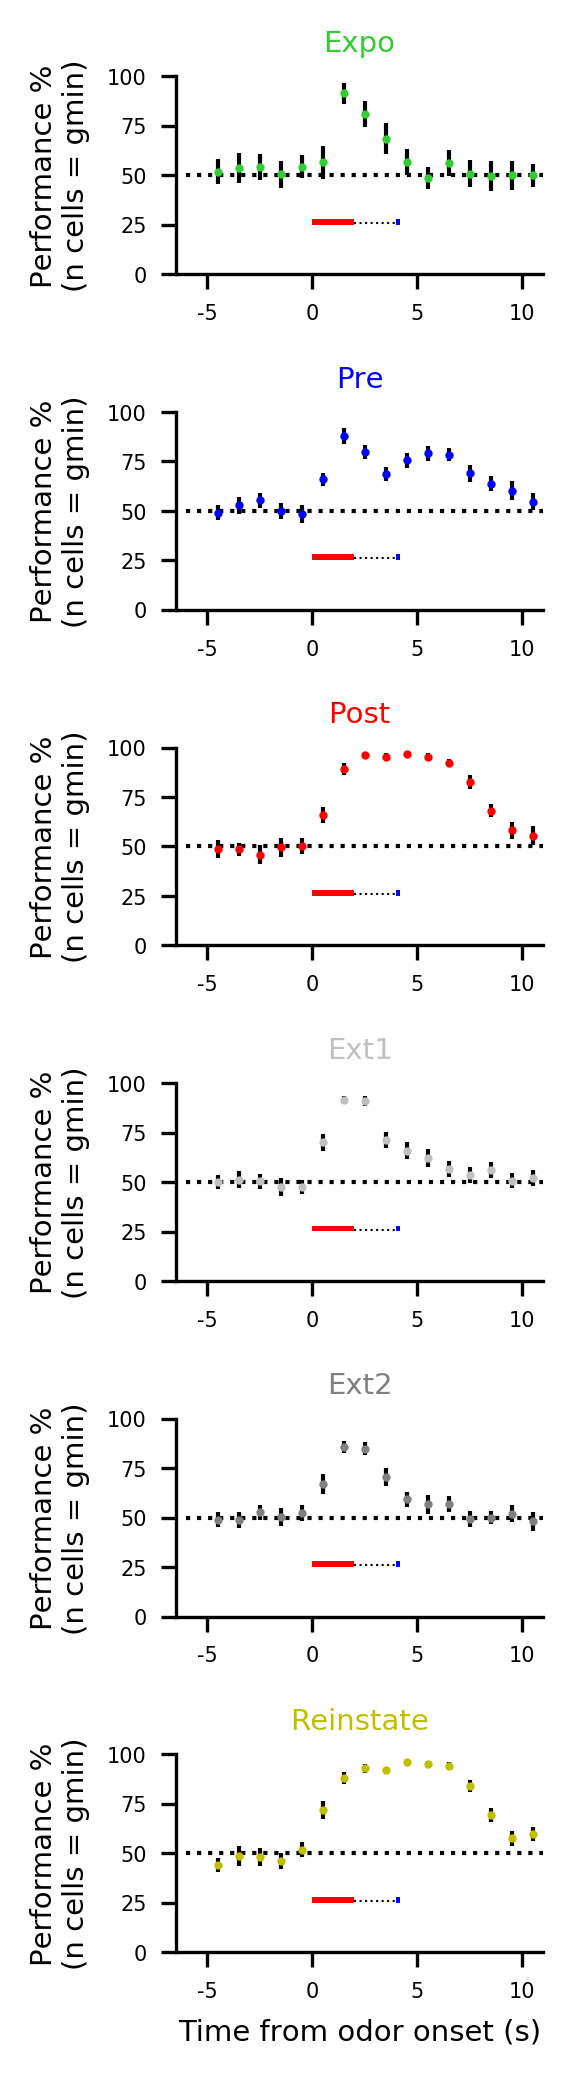

In [25]:
fig, ax = pl.subplots(6,1, figsize=(2, 7))

#t = np.arange(t_start0, t_stop0, delta_t0)
# ax.fill_between(t+np.diff(t)[0]/2.,
#                 (scores.mean(1) + np.std(scores, 1))*100,
#                 (scores.mean(1) - np.std(scores, 1))*100,
#                 lw=0, color='0.8')
for t in range(0,16):
    ax[0].plot(t-4.5, np.mean(eval("scores_gmin_tb_%s['expo']"%t))*100, 'o', color='limegreen', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_gmin_tb_%s['expo']"%t))*100
    s = np.std(eval("scores_gmin_tb_%s['expo']"%t))*100 / np.sqrt(eval("scores_gmin_tb_%s['expo']"%t).shape[-1])
    ax[0].errorbar(t-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[1].plot(t-4.5, np.mean(eval("scores_gmin_tb_%s['pre']"%t))*100, 'o', color='blue', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_gmin_tb_%s['pre']"%t))*100
    s = np.std(eval("scores_gmin_tb_%s['pre']"%t))*100 / np.sqrt(eval("scores_gmin_tb_%s['pre']"%t).shape[-1])
    ax[1].errorbar(t-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[2].plot(t-4.5, np.mean(eval("scores_gmin_tb_%s['post']"%t))*100, 'o', color='red', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_gmin_tb_%s['post']"%t))*100
    s = np.std(eval("scores_gmin_tb_%s['post']"%t))*100 / np.sqrt(eval("scores_gmin_tb_%s['post']"%t).shape[-1])
    ax[2].errorbar(t-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[3].plot(t-4.5, np.mean(eval("scores_gmin_tb_%s['ext1']"%t))*100, 'o', color='silver', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_gmin_tb_%s['ext1']"%t))*100
    s = np.std(eval("scores_gmin_tb_%s['ext1']"%t))*100 / np.sqrt(eval("scores_gmin_tb_%s['ext1']"%t).shape[-1])
    ax[3].errorbar(t-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[4].plot(t-4.5, np.mean(eval("scores_gmin_tb_%s['ext2']"%t))*100, 'o', color='grey', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_gmin_tb_%s['ext2']"%t))*100
    s = np.std(eval("scores_gmin_tb_%s['ext2']"%t))*100 / np.sqrt(eval("scores_gmin_tb_%s['ext2']"%t).shape[-1])
    ax[4].errorbar(t-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[5].plot(t-4.5, np.mean(eval("scores_gmin_tb_%s['renew']"%t))*100, 'o', color='y', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_gmin_tb_%s['renew']"%t))*100
    s = np.std(eval("scores_gmin_tb_%s['renew']"%t))*100 / np.sqrt(eval("scores_gmin_tb_%s['renew']"%t).shape[-1])
    ax[5].errorbar(t-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
for x in range (0,6):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-6.5, 11)
    ax[x].set_xticks(np.arange(-5,11, 5))
    ax[x].set_xticklabels(np.arange(-5,11, 5))
    ax[x].hlines(50, -6,11, color='k', lw=1, linestyles='dotted')
    ax[5].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %\n(n cells = gmin)')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Expo', color='limegreen')
ax[1].set_title('Pre', color = 'b')
ax[2].set_title('Post', color = 'r')
ax[3].set_title('Ext1', color = 'silver')
ax[4].set_title('Ext2', color = 'grey')
ax[5].set_title('Reinstate', color = 'y')
fig.tight_layout(pad=2)


fig.savefig('../img/%s_gmin.jpg'%NOTEBOOK_NAME)

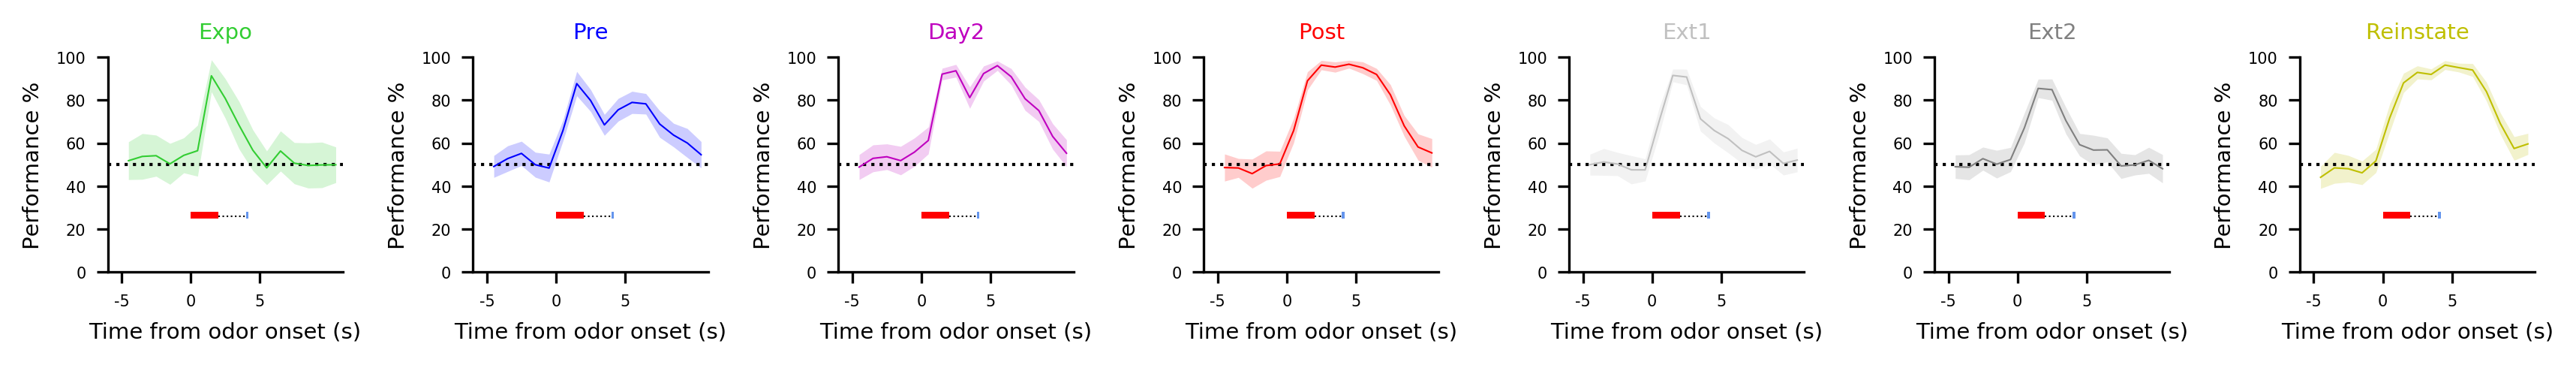

In [26]:
fig, ax = pl.subplots(1,7, figsize=(11.5, 1.7))

for r,sess,c in zip(range(7),sessions,('limegreen','b','m','r','silver','grey','y')):
    ax[r].plot([(t-4.5) for t in range(16)], [(np.mean(eval("scores_gmin_tb_%s[sess]"%t))*100) for t in range(16)], color=c, ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.array([(np.mean(eval("scores_gmin_tb_%s[sess]"%t))*100) for t in range(16)])
    s = np.array([np.std(eval("scores_gmin_tb_%s[sess]"%t))*100 for t in range(16)])
    ax[r].fill_between([(t-4.5) for t in range(16)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (0,7):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-6, 11)
    ax[x].set_xticks(np.arange(-5,10, 5))
    ax[x].set_xticklabels(np.arange(-5,10, 5))
    ax[x].hlines(50, -6,11, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='cornflowerblue', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Expo', color='limegreen')
ax[1].set_title('Pre', color = 'b')
ax[2].set_title('Day2', color = 'm')
ax[3].set_title('Post', color = 'r')
ax[4].set_title('Ext1', color = 'silver')
ax[5].set_title('Ext2', color = 'grey')
ax[6].set_title('Reinstate', color = 'y')
fig.tight_layout(pad=2)


fig.savefig('../img/%s_gmin_horizontal.pdf'%NOTEBOOK_NAME)

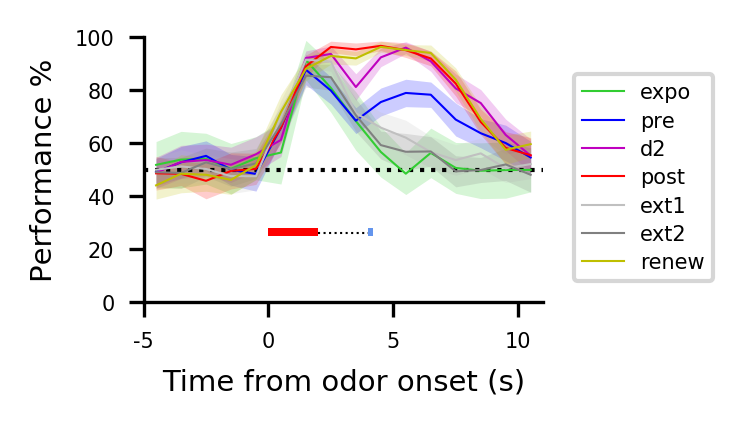

In [27]:
fig, ax = pl.subplots(1,1, figsize=(2, 1.5))

for sess,c in zip(sessions,('limegreen','b','m','r','silver','grey','y')):
    ax.plot([(t-4.5) for t in range(16)], [(np.mean(eval("scores_gmin_tb_%s[sess]"%t))*100) for t in range(16)], color=c,label=sess)
    m = np.array([(np.mean(eval("scores_gmin_tb_%s[sess]"%t))*100) for t in range(16)])
    s = np.array([np.std(eval("scores_gmin_tb_%s[sess]"%t))*100 for t in range(16)])
    ax.fill_between([(t-4.5) for t in range(16)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
ax.set_ylim(0, 100)
ax.set_xlim(-5, 11)
ax.set_xticks(np.arange(-5,11, 5))
ax.set_xticklabels(np.arange(-5,11, 5))
ax.hlines(50, -5,11, color='k', lw=1, linestyles='dotted')
ax.set_xlabel('Time from odor onset (s)')
ax.set_ylabel('Performance %')
pt.plot_period_bar(ax, 25, start_end=(0, 2), color='r', delta_y=3)
pt.plot_period_bar(ax, 25, start_end=(4, 4.2), color='cornflowerblue', delta_y=3)
ax.hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax.legend(bbox_to_anchor=(1.05,.9),labelspacing=0.4,fontsize=5)
#ax[0].set_title('Expo', color='limegreen')
#ax[1].set_title('Pre', color = 'b')
#ax[2].set_title('Post', color = 'r')
#ax[3].set_title('Ext1', color = 'silver')
#ax[4].set_title('Ext2', color = 'grey')
#ax[5].set_title('Reinstate', color = 'y')
fig.tight_layout(pad=2)


fig.savefig('../img/%s_gmin_combined.pdf'%NOTEBOOK_NAME)

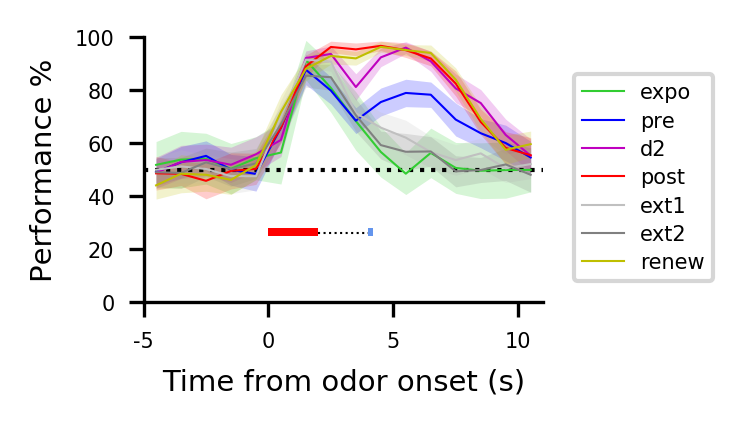

In [28]:
fig, ax = pl.subplots(1,1, figsize=(2, 1.5))

for sess,c in zip(sessions,('limegreen','b','m','r','silver','grey','y')):
    ax.plot([(t-4.5) for t in range(16)], [(np.mean(eval("scores_gmin_tb_%s[sess]"%t))*100) for t in range(16)], color=c,label=sess)
    m = np.array([(np.mean(eval("scores_gmin_tb_%s[sess]"%t))*100) for t in range(16)])
    s = np.array([np.std(eval("scores_gmin_tb_%s[sess]"%t))*100 for t in range(16)])
    ax.fill_between([(t-4.5) for t in range(16)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
ax.set_ylim(0, 100)
ax.set_xlim(-5, 11)
ax.set_xticks(np.arange(-5,11, 5))
ax.set_xticklabels(np.arange(-5,11, 5))
ax.hlines(50, -5,11, color='k', lw=1, linestyles='dotted')
ax.set_xlabel('Time from odor onset (s)')
ax.set_ylabel('Performance %')
pt.plot_period_bar(ax, 25, start_end=(0, 2), color='r', delta_y=3)
pt.plot_period_bar(ax, 25, start_end=(4, 4.2), color='cornflowerblue', delta_y=3)
ax.hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax.legend(bbox_to_anchor=(1.05,.9),labelspacing=0.4,fontsize=5)
#ax[0].set_title('Expo', color='limegreen')
#ax[1].set_title('Pre', color = 'b')
#ax[2].set_title('Post', color = 'r')
#ax[3].set_title('Ext1', color = 'silver')
#ax[4].set_title('Ext2', color = 'grey')
#ax[5].set_title('Reinstate', color = 'y')
fig.tight_layout(pad=2)


fig.savefig('../img/%s_gmin_combined.pdf'%NOTEBOOK_NAME)

## decode using subset of trials

In [27]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within_subsets(patterns, labels, n_cells=None,start_trial=None,end_trial=None):
#     which_train = range(90)
#     which_test = range(90)
#    cv =LeaveOneOut()
    
    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        #split trials into train and test
        if start_trial != None:   #take subset of trials?
            which_train_aa = np.random.permutation(np.where(labels[ani][start_trial:end_trial]==0)[0])
            which_train_a = which_train_aa+start_trial
        else:
            which_train_a = np.random.permutation(np.where(labels[ani]==0)[0])
        which_test_a = which_train_a[:len(which_train_a)/2]
        which_train_a = which_train_a[len(which_train_a)/2:]
        
        if start_trial != None:   #take subset of trials?
            which_train_bb = np.random.permutation(np.where(labels[ani][start_trial:end_trial]==1)[0])
            which_train_b = which_train_bb+start_trial
        else:
            which_train_b = np.random.permutation(np.where(labels[ani]==1)[0])
        which_test_b = which_train_b[:len(which_train_b)/2]
        which_train_b = which_train_b[len(which_train_b)/2:]
        
        which_train[ani] = np.concatenate((which_train_a, which_train_b))
        which_test[ani] = np.concatenate((which_test_a, which_test_b))
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    patterns_T = patterns.copy()
    labels_T = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
        patterns_T[ani] = patterns[ani][which_test[ani]]
        labels_T[ani] = labels[ani][which_test[ani]]
    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_t, labels_t)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_T, labels_T)
    
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
        
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    scores = decoder.score(patterns_comb_test[:, cells], labels_comb)
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb))

In [28]:
%%time
#decode using subset of trials and gmin cells
n_loops = 30
for t in range(16):
        for phase,trls in zip(['early','mid','late'],[(0,40),(41,80),(81,120)]):
            exec("scores_gmin_tb_%s_%s = {}"%(t,phase))
            for sess in sessions[1:]:
                exec("scores_gmin_tb_%s_%s[sess] = [do_test_within_subsets(patterns_tb_%s_%s,\
                      labels_%s, n_cells=gmin,start_trial=%s, end_trial=%s) for i in range(n_loops)]"%(t,phase,
                                                                                    t,sess,sess,trls[0],trls[1]))
        print t,"DONE!    ",

0 DONE!     1 DONE!     2 DONE!     3 DONE!     4 DONE!     5 DONE!     6 DONE!     7 DONE!     8 DONE!     9 DONE!     10 DONE!     11 DONE!     12 DONE!     13 DONE!     14 DONE!     15 DONE!    CPU times: user 5min 33s, sys: 304 ms, total: 5min 34s
Wall time: 5min 33s



In [29]:
%%time
#decode using subset of trials and gmin cells
n_loops = 30
for t in range(16):
        for phase,trls in zip(['Trials1to30','Trials31to60','Trials61to90','Trials91to120'],[(0,30),(30,60),(60,90),(90,120)]):
            exec("scores_gmin_tb_%s_%s = {}"%(t,phase))
            for sess in sessions[1:]:
                exec("scores_gmin_tb_%s_%s[sess] = [do_test_within_subsets(patterns_tb_%s_%s,\
                      labels_%s, n_cells=gmin,start_trial=%s, end_trial=%s) for i in range(n_loops)]"%(t,phase,
                                                                                    t,sess,sess,trls[0],trls[1]))
        print t,"DONE!    ",

0 DONE!     1 DONE!     2 DONE!     3 DONE!     4 DONE!     5 DONE!     6 DONE!     7 DONE!     8 DONE!     9 DONE!     10 DONE!     11 DONE!     12 DONE!     13 DONE!     14 DONE!     15 DONE!    CPU times: user 6min 47s, sys: 352 ms, total: 6min 47s
Wall time: 6min 47s



In [30]:
%%time
#decode using subset of trials and gmin cells
n_loops = 30
for t in range(16):
        for phase,trls in zip(['Trials1to20','Trials21to40','Trials81to100','Trials101to120'],
                              [(0,20),(21,40),(81,100),(101,120)]):
            exec("scores_gmin_tb_%s_%s = {}"%(t,phase))
            for sess in sessions[1:]:
                exec("scores_gmin_tb_%s_%s[sess] = [do_test_within_subsets(patterns_tb_%s_%s,\
                      labels_%s, n_cells=gmin,start_trial=%s, end_trial=%s) for i in range(n_loops)]"%(t,phase,
                                                                                    t,sess,sess,trls[0],trls[1]))
        print t,"DONE!    ",

0 DONE!     1 DONE!     2 DONE!     3 DONE!     4 DONE!     5 DONE!     6 DONE!     7 DONE!     8 DONE!     9 DONE!     10 DONE!     11 DONE!     12 DONE!     13 DONE!     14 DONE!     15 DONE!    CPU times: user 6min 6s, sys: 320 ms, total: 6min 7s
Wall time: 6min 6s



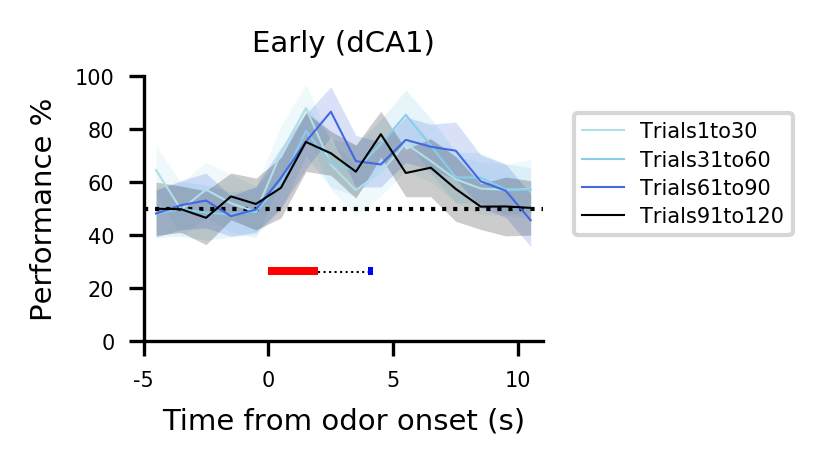

In [31]:
fig, ax = pl.subplots(1,1, figsize=(2, 1.5))

for phase,c in zip(['Trials1to30','Trials31to60','Trials61to90','Trials91to120'],(('powderblue','skyblue','royalblue','k'))):
    ax.plot([(t-4.5) for t in range(16)], [(np.mean(eval("scores_gmin_tb_%s_%s['pre']"%(t,phase)))*100) for t in range(16)], color=c,label=phase)
    m = np.array([(np.mean(eval("scores_gmin_tb_%s_%s['pre']"%(t,phase)))*100) for t in range(16)])
    s = np.array([np.std(eval("scores_gmin_tb_%s_%s['pre']"%(t,phase)))*100 for t in range(16)])
    ax.fill_between([(t-4.5) for t in range(16)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
ax.set_ylim(0, 100)
ax.set_xlim(-5, 11)
ax.set_xticks(np.arange(-5,11, 5))
ax.set_xticklabels(np.arange(-5,11, 5))
ax.hlines(50, -5,11, color='k', lw=1, linestyles='dotted')
ax.set_xlabel('Time from odor onset (s)')
ax.set_ylabel('Performance %')
pt.plot_period_bar(ax, 25, start_end=(0, 2), color='r', delta_y=3)
pt.plot_period_bar(ax, 25, start_end=(4, 4.2), color='b', delta_y=3)
ax.hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax.legend(bbox_to_anchor=(1.05,.9),labelspacing=0.4,fontsize=5)
fig.tight_layout(pad=2)
ax.set_title('Early (dCA1)')


#fig.savefig('../img/%s_gmin_combined.pdf'%NOTEBOOK_NAME)

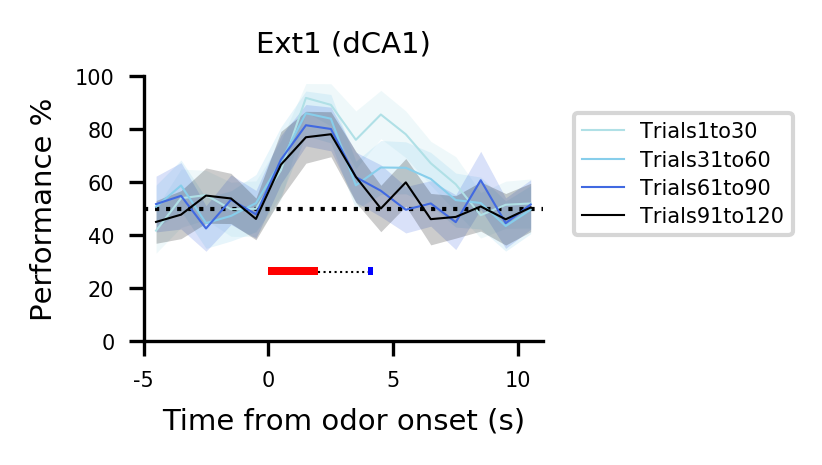

In [32]:
fig, ax = pl.subplots(1,1, figsize=(2, 1.5))

for phase,c in zip(['Trials1to30','Trials31to60','Trials61to90','Trials91to120'],(('powderblue','skyblue','royalblue','k'))):
    ax.plot([(t-4.5) for t in range(16)], [(np.mean(eval("scores_gmin_tb_%s_%s['ext1']"%(t,phase)))*100) for t in range(16)], color=c,label=phase)
    m = np.array([(np.mean(eval("scores_gmin_tb_%s_%s['ext1']"%(t,phase)))*100) for t in range(16)])
    s = np.array([np.std(eval("scores_gmin_tb_%s_%s['ext1']"%(t,phase)))*100 for t in range(16)])
    ax.fill_between([(t-4.5) for t in range(16)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
ax.set_ylim(0, 100)
ax.set_xlim(-5, 11)
ax.set_xticks(np.arange(-5,11, 5))
ax.set_xticklabels(np.arange(-5,11, 5))
ax.hlines(50, -5,11, color='k', lw=1, linestyles='dotted')
ax.set_xlabel('Time from odor onset (s)')
ax.set_ylabel('Performance %')
pt.plot_period_bar(ax, 25, start_end=(0, 2), color='r', delta_y=3)
pt.plot_period_bar(ax, 25, start_end=(4, 4.2), color='b', delta_y=3)
ax.hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax.legend(bbox_to_anchor=(1.05,.9),labelspacing=0.4,fontsize=5)
fig.tight_layout(pad=2)
ax.set_title('Ext1 (dCA1)')


#fig.savefig('../img/%s_gmin_combined.pdf'%NOTEBOOK_NAME)

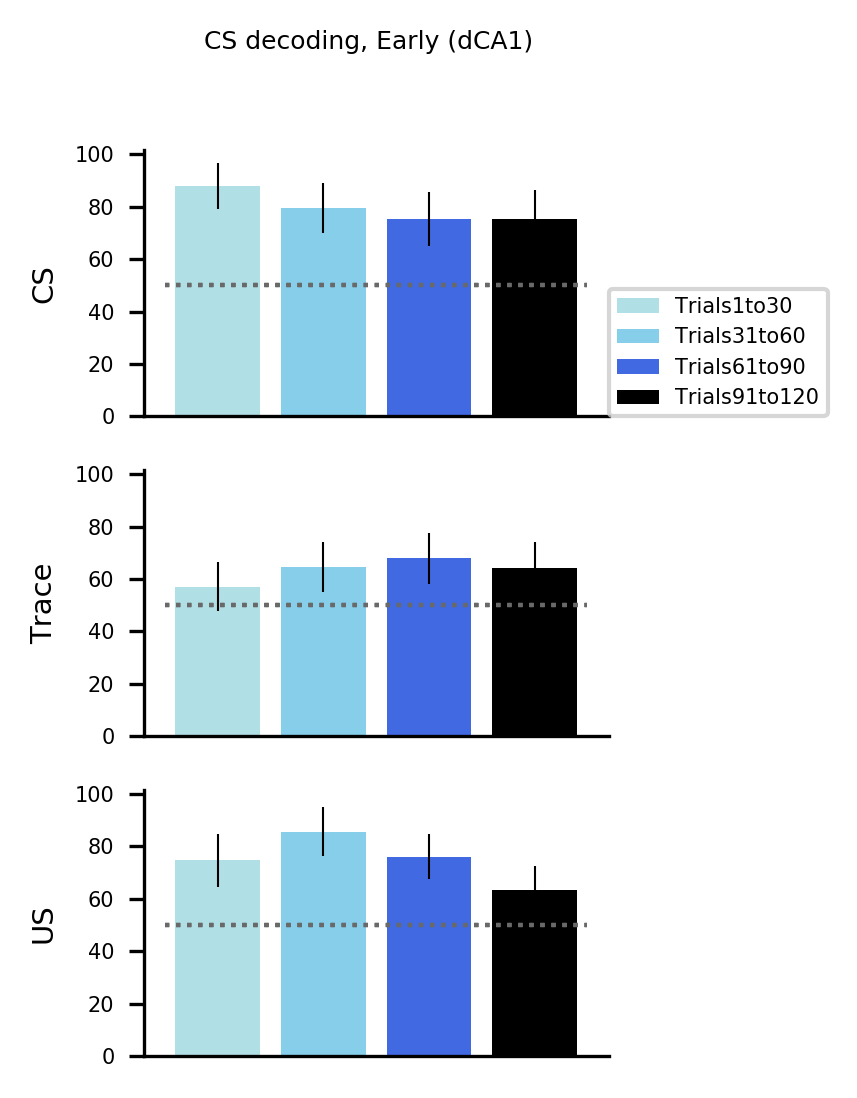

In [33]:
fig,ax = pl.subplots(3,1,figsize=(2,4),sharex=True,sharey=True)

for phase,c,z in zip(['Trials1to30','Trials31to60','Trials61to90','Trials91to120'],(('powderblue','skyblue','royalblue','k')),range(4)):
    for tb,tb_la,r in zip((6,8,10),('CS','Trace','US',),(range(3))):
        s = np.array(np.std(eval("scores_gmin_tb_%s_%s['pre']"%(tb,phase)))*100)
        ax[r].bar(z, (np.mean(eval("scores_gmin_tb_%s_%s['pre']"%(tb,phase)))*100), color=c,label=phase,yerr=s)
        ax[r].tick_params(axis='x',bottom=False,labelbottom=False) # labels along the bottom edge are off
        ax[r].set_ylabel(tb_la)
        ax[r].hlines(50, -.5,3.5, color='dimgrey', lw=1, linestyles='dotted')
ax[0].legend(loc=(1,0))
pl.suptitle('CS decoding, Early (dCA1)')
    

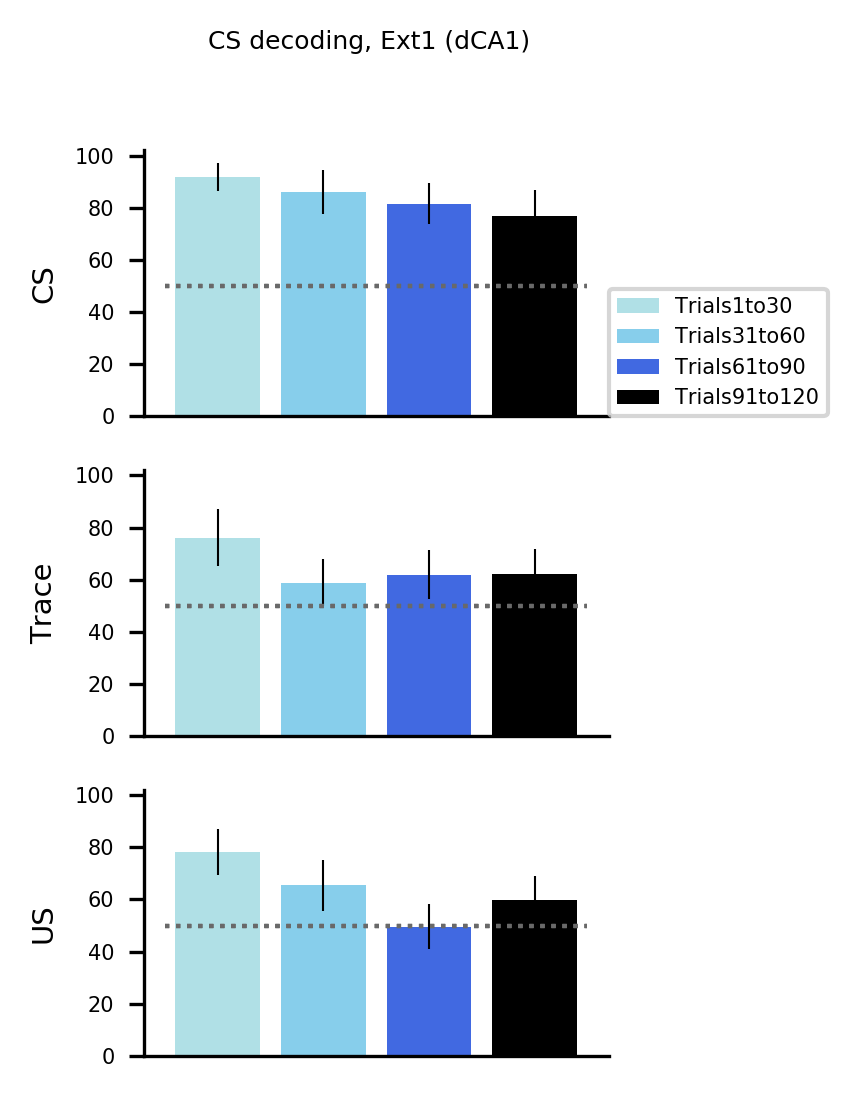

In [34]:
fig,ax = pl.subplots(3,1,figsize=(2,4),sharex=True,sharey=True)

for phase,c,z in zip(['Trials1to30','Trials31to60','Trials61to90','Trials91to120'],(('powderblue','skyblue','royalblue','k')),range(4)):
    for tb,tb_la,r in zip((6,8,10),('CS','Trace','US',),(range(3))):
        s = np.array(np.std(eval("scores_gmin_tb_%s_%s['ext1']"%(tb,phase)))*100)
        ax[r].bar(z, (np.mean(eval("scores_gmin_tb_%s_%s['ext1']"%(tb,phase)))*100), color=c,label=phase,yerr=s)
        ax[r].tick_params(axis='x',bottom=False,labelbottom=False) # labels along the bottom edge are off
        ax[r].set_ylabel(tb_la)
        ax[r].hlines(50, -.5,3.5, color='dimgrey', lw=1, linestyles='dotted')

ax[0].legend(loc=(1,0))
pl.suptitle('CS decoding, Ext1 (dCA1)')
    

In [35]:
%%time
#decode using subset of trials and all cells
n_loops = 30
for t in range(16):
        exec("scores_gmin_tb_%s_20onward = {}"%(t))
        for sess in sessions[1:]:
            exec("scores_gmin_tb_%s_20onward[sess] = [do_test_within_subsets(patterns_tb_%s_%s,\
                  labels_%s, n_cells=gmin,start_trial=20, end_trial=120) for i in range(n_loops)]"%(t,
                                                                                t,sess,sess))
        print t,"DONE!    ",

0 DONE!     1 DONE!     2 DONE!     3 DONE!     4 DONE!     5 DONE!     6 DONE!     7 DONE!     8 DONE!     9 DONE!     10 DONE!     11 DONE!     12 DONE!     13 DONE!     14 DONE!     15 DONE!    CPU times: user 2min 32s, sys: 168 ms, total: 2min 33s
Wall time: 2min 32s



# And now for decoding across time bins!

In [36]:
from sklearn.svm import SVC

decoder = SVC(kernel='linear', decision_function_shape='ovo')
def do_test_cross(patterns_t, labels_t, patterns_T, labels_T, n_cells=None):
#     which_train = range(90)
#     which_test = range(90)
    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_t, labels_t)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_T, labels_T)
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    scores = decoder.score(patterns_comb_test[:, cells], labels_comb)
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb))

In [37]:
gmin = np.min((total_cells_pre_vHPC,total_cells_pre_dHPC, total_cells_post_vHPC,total_cells_post_dHPC,
                total_cells_ext1_vHPC,total_cells_ext1_dHPC, total_cells_ext2_vHPC,total_cells_ext2_dHPC,
                total_cells_renew_vHPC,total_cells_renew_dHPC, total_cells_expo_vHPC,total_cells_expo_dHPC))

In [38]:
##STOP!!! running this takes 5ish hours
#%%time
#ncells=gmin
#n_loops=25
#for t in range (0,16):
#    for c in range (0,16):
#        exec('scores_gmin_tb_%s_VS_%s = {}'%(t,c))
#        for sess in sessions:
#            print sess,t,c
#            print " ",
#            eval('scores_gmin_tb_%s_VS_%s'%(t,c))[sess] = np.r_[[do_test_cross(eval('patterns_tb_%s_%s'%(t,sess)),eval('labels_%s'%sess),
#                                                                eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),n_cells=gmin) for i in range(n_loops)]]

In [39]:
#for t in range (16):
#    exec('testy%s = {}'%t)
#for sess in sessions:
#    for t in range (0,16):
#        exec("testy%s['%s'] = []"%(t,sess))
#        for c in range (0,16):
#            #print eval('testy%s'%t)[sess]
#            eval('testy%s'%t)[sess].insert(c,(eval('scores_gmin_tb_%s_VS_%s'%(t,c))[sess].mean(1)).mean())

In [40]:
##and now replace cross-session decoding score with within-session score where test and train data are from the same time bin
#for sess in sessions:
#    for t in range (16):
#        eval('testy%s'%t)[sess][t] = eval("scores_gmin_tb_%s"%t)[sess].mean()

In [41]:
#testy={}
#for sess in sessions:
#    testy[sess]=(testy0[sess], testy1[sess], testy2[sess], testy3[sess], testy4[sess], testy5[sess], testy6[sess], testy7[sess],
#                 testy8[sess], testy9[sess], testy10[sess], testy11[sess], testy12[sess], testy13[sess], testy14[sess], testy15[sess])
#    np.array([testy[sess]])

In [42]:
#pl.imshow(testy['expo'], cmap='hot', interpolation='nearest')
#pl.show()

In [43]:
#fig, ax = pl.subplots(6, 1, figsize=(3, 15))#, sharex=True, sharey=True)
#vmin=0.5
#vmax=1
#im = ax[0].imshow(testy['expo'],origin='lower', interpolation='nearest',vmin=vmin, vmax=vmax)
#im = ax[1].imshow(testy['pre'],origin='lower', interpolation='nearest',vmin=vmin, vmax=vmax)
#im = ax[2].imshow(testy['post'],origin='lower', interpolation='nearest',vmin=vmin, vmax=vmax)
#im = ax[3].imshow(testy['ext1'],origin='lower', interpolation='nearest',vmin=vmin, vmax=vmax)
#im = ax[4].imshow(testy['ext2'],origin='lower', interpolation='nearest',vmin=vmin, vmax=vmax)
#im = ax[5].imshow(testy['renew'],origin='lower', interpolation='nearest',vmin=vmin,vmax=vmax)
#
#for x in range (0,6):
#    ax[x].set_xticks(range(16))
#    ax[x].set_yticks(range(16))
#    ax[x].set_ylim(2.5, 14.5)
#    ax[x].set_xlim(2.5,14.5)
#    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0\n(CS)','1\n(CS)','2\n(Tr)','3\n(Tr)','4\n(Rw)','5', '6','7','8','9','10'])
#    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','(CS) 0','(CS) 1','(Tr) 2','(Tr) 3','(Rw) 4','5', '6','7','8','9','10'])
#    ax[x].set_ylabel('Time(s) from CS onset', fontsize=5)
#    ax[x].set_xlabel('Time(s) from CS onset', fontsize=5)
#
## axs[0].set_xticklabels(np.arange(len(np.unique(labels)))+1)
## axs[0].set_yticklabels(np.arange(len(np.unique(labels)))+1)
#
#ax[0].set_title('Decoding Across Time Bins, Expo', fontsize=7, color='limegreen')
#ax[1].set_title('Pre', fontsize=7, color='b')
#ax[2].set_title('Post', fontsize=7, color='r')
#ax[3].set_title('Ext1', fontsize=7, color='silver')
#ax[4].set_title('Ext2', fontsize=7, color='grey')
#ax[5].set_title('Reinstate', fontsize=7, color='y')
#
#cax = fig.add_axes([.85, 0.86, 0.05, 0.117])
#fig.colorbar(im, cax=cax)
#fig.tight_layout(pad=2.5)
#fig.savefig('../img/%s_gmin_across_bins.jpg'%NOTEBOOK_NAME)

# now, use distinct trials for train and test for decoding across time bins

In [44]:
#trying to use different trials for different time bins
from sklearn.svm import SVC
decoder = SVC(kernel='linear', decision_function_shape='ovo')

def do_test_cross_distinct(patterns_t, labels_t, patterns_T, labels_T, n_cells=None):
    which_train = {}
    which_test = {}
    for ani in patterns_t.keys():
        which_train_a = np.random.permutation(np.where(labels_t[ani]==0)[0])
        which_test_a = which_train_a[:len(which_train_a)/2]
        which_train_a = which_train_a[len(which_train_a)/2:]
        
        which_train_b = np.random.permutation(np.where(labels_t[ani]==1)[0])
        which_test_b = which_train_b[:len(which_train_b)/2]
        which_train_b = which_train_b[len(which_train_b)/2:]
        
        which_train[ani] = np.concatenate((which_train_a, which_train_b))
        which_test[ani] = np.concatenate((which_test_a, which_test_b))
    patterns_dt = patterns_t.copy()
    labels_dt = labels_t.copy()
    patterns_dT = patterns_T.copy()
    labels_dT = labels_T.copy()
    for ani in patterns_t.keys():
        patterns_dt[ani] = patterns_dt[ani][which_train[ani]]
        labels_dt[ani] = labels_dt[ani][which_train[ani]]
        patterns_dT[ani] = patterns_dT[ani][which_test[ani]]
        labels_dT[ani] = labels_dT[ani][which_test[ani]]      
        
    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_dt, labels_dt)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_dT, labels_dT)
    
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
    
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    scores = decoder.score(patterns_comb_test[:, cells], labels_comb)
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb))

In [45]:
%%time
ncells=gmin
n_loops=30
for t in range (16):
    for c in range (16):
        exec('scores_gmin_tb_distinct_%s_VS_%s = {}'%(t,c))
        for sess in sessions:
            print sess,t,c,
            print' ',
            eval('scores_gmin_tb_distinct_%s_VS_%s'%(t,c))[sess] = np.r_[[do_test_cross_distinct(eval('patterns_tb_%s_%s'%(t,sess)),eval('labels_%s'%sess),
                                                                eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),n_cells=gmin) for i in range(n_loops)]]

expo 0 0   pre 0 0   d2 0 0   post 0 0   ext1 0 0   ext2 0 0   renew 0 0   expo 0 1   pre 0 1   d2 0 1   post 0 1   ext1 0 1   ext2 0 1   renew 0 1   expo 0 2   pre 0 2   d2 0 2   post 0 2   ext1 0 2   ext2 0 2   renew 0 2   expo 0 3   pre 0 3   d2 0 3   post 0 3   ext1 0 3   ext2 0 3   renew 0 3   expo 0 4   pre 0 4   d2 0 4   post 0 4   ext1 0 4   ext2 0 4   renew 0 4   expo 0 5   pre 0 5   d2 0 5   post 0 5   ext1 0 5   ext2 0 5   renew 0 5   expo 0 6   pre 0 6   d2 0 6   post 0 6   ext1 0 6   ext2 0 6   renew 0 6   expo 0 7   pre 0 7   d2 0 7   post 0 7   ext1 0 7   ext2 0 7   renew 0 7   expo 0 8   pre 0 8   d2 0 8   post 0 8   ext1 0 8   ext2 0 8   renew 0 8   expo 0 9   pre 0 9   d2 0 9   post 0 9   ext1 0 9   ext2 0 9   renew 0 9   expo 0 10   pre 0 10   d2 0 10   post 0 10   ext1 0 10   ext2 0 10   renew 0 10   expo 0 11   pre 0 11   d2 0 11   post 0 11   ext1 0 11   ext2 0 11   renew 0 11   expo 0 12   pre 0 12   d2 0 12   post 0 12   ext1 0 12   ext2 0 12   renew 0 12   expo

## getting reciprocal train and test with function above, but will only extract one way with analysis below

In [46]:
for t in range (16):
    exec('distinct%s = {}'%t)
for sess in sessions:
    for t in range (16):
        exec("distinct%s['%s'] = []"%(t,sess))
        for c in range (16):
            #print eval('testy%s'%t)[sess]
            eval('distinct%s'%t)[sess].insert(c,(eval('scores_gmin_tb_distinct_%s_VS_%s'%(t,c))[sess]).mean(0)[0])

In [47]:
for t in range (16):
    exec('distinct%s_ttest = {}'%t)
for sess in sessions:
    for t in range (16):
        exec("distinct%s_ttest['%s'] = []"%(t,sess))
        for c in range (16):
            eval('distinct%s_ttest'%t)[sess].insert(c,
                (sstats.ttest_1samp(eval('scores_gmin_tb_distinct_%s_VS_%s[sess][:,0][:15]'%(t,c)),.5)))
        for x,i in zip(eval('distinct%s_ttest'%t)[sess],range(len(eval('distinct%s_ttest'%t)[sess]))):
            exec("distinct%s_ttest[sess][i] = x[-1]"%(t)) #only take p-values

In [48]:
for t in range (16):
    exec('distinct%s_wilcox = {}'%t)
for sess in sessions:
    for t in range (16):
        exec("distinct%s_wilcox['%s'] = []"%(t,sess))
        for c in range (16):
            exec("subtracted = [x-0.5 for x in scores_gmin_tb_distinct_%s_VS_%s[sess][:,0]]"%(t,c))
            eval('distinct%s_wilcox'%t)[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
        for x,i in zip(eval('distinct%s_wilcox'%t)[sess],range(len(eval('distinct%s_wilcox'%t)[sess]))):
            exec("distinct%s_wilcox[sess][i] = x[-1]"%(t)) #only take p-values

/home/fabios/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [49]:
distinct={}
for sess in sessions:
    distinct[sess]=(distinct0[sess], distinct1[sess], distinct2[sess], distinct3[sess], distinct4[sess], distinct5[sess], distinct6[sess], distinct7[sess],
                 distinct8[sess], distinct9[sess], distinct10[sess], distinct11[sess], distinct12[sess], distinct13[sess], distinct14[sess], distinct15[sess])
    np.array([distinct[sess]])

In [50]:
distinct_ttest={}
for sess in sessions:
    distinct_ttest[sess]=(distinct0_ttest[sess], distinct1_ttest[sess], distinct2_ttest[sess], distinct3_ttest[sess],
                          distinct4_ttest[sess], distinct5_ttest[sess], distinct6_ttest[sess], distinct7_ttest[sess],
                          distinct8_ttest[sess], distinct9_ttest[sess], distinct10_ttest[sess], distinct11_ttest[sess],
                          distinct12_ttest[sess], distinct13_ttest[sess], distinct14_ttest[sess], distinct15_ttest[sess])
    np.array([distinct_ttest[sess]])

In [51]:
distinct_wilcox={}
for sess in sessions:
    distinct_wilcox[sess]=(distinct0_wilcox[sess], distinct1_wilcox[sess], distinct2_wilcox[sess], distinct3_wilcox[sess],
                          distinct4_wilcox[sess], distinct5_wilcox[sess], distinct6_wilcox[sess], distinct7_wilcox[sess],
                          distinct8_wilcox[sess], distinct9_wilcox[sess], distinct10_wilcox[sess], distinct11_wilcox[sess],
                          distinct12_wilcox[sess], distinct13_wilcox[sess], distinct14_wilcox[sess], distinct15_wilcox[sess])
    np.array([distinct_wilcox[sess]])

In [52]:
#fig, ax = pl.subplots(6, 1, figsize=(3, 15))#, sharex=True, sharey=True)
#vmin=0.5
#vmax=1
#im = ax[0].imshow(distinct['expo'],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax)
#im = ax[1].imshow(distinct['pre'],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax)
#im = ax[2].imshow(distinct['post'],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax)
#im = ax[3].imshow(distinct['ext1'],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax)
#im = ax[4].imshow(distinct['ext2'],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax)
#im = ax[5].imshow(distinct['renew'],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax)
#
#for x in range (0,6):
#    ax[x].set_xticks(range(16))
#    ax[x].set_yticks(range(16))
#    ax[x].set_ylim(2.5, 14.5)
#    ax[x].set_xlim(2.5,14.5)
#    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0\n(CS)','1\n(CS)','2\n(Tr)','3\n(Tr)','4\n(Rw)','5', '6','7','8','9','10'])
#    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','(CS) 0','(CS) 1','(Tr) 2','(Tr) 3','(Rw) 4','5', '6','7','8','9','10'])
#    ax[x].set_ylabel('Time(s) from CS onset', fontsize=5)
#    ax[x].set_xlabel('Time(s) from CS onset', fontsize=5)
#
## axs[0].set_xticklabels(np.arange(len(np.unique(labels)))+1)
## axs[0].set_yticklabels(np.arange(len(np.unique(labels)))+1)
#
#ax[0].set_title('vHPC Decoding Across Time Bin\nExpo', fontsize=7, color='limegreen')
#ax[1].set_title('Pre', fontsize=7, color='b')
#ax[2].set_title('Post', fontsize=7, color='r')
#ax[3].set_title('Ext1', fontsize=7, color='silver')
#ax[4].set_title('Ext2', fontsize=7, color='grey')
#ax[5].set_title('Reinstate', fontsize=7, color='y')
#
#cax = fig.add_axes([.83, 0.854, 0.05, 0.117])
#fig.colorbar(im, cax=cax)
#fig.tight_layout(pad=2.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct.jpg'%NOTEBOOK_NAME)

/home/fabios/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


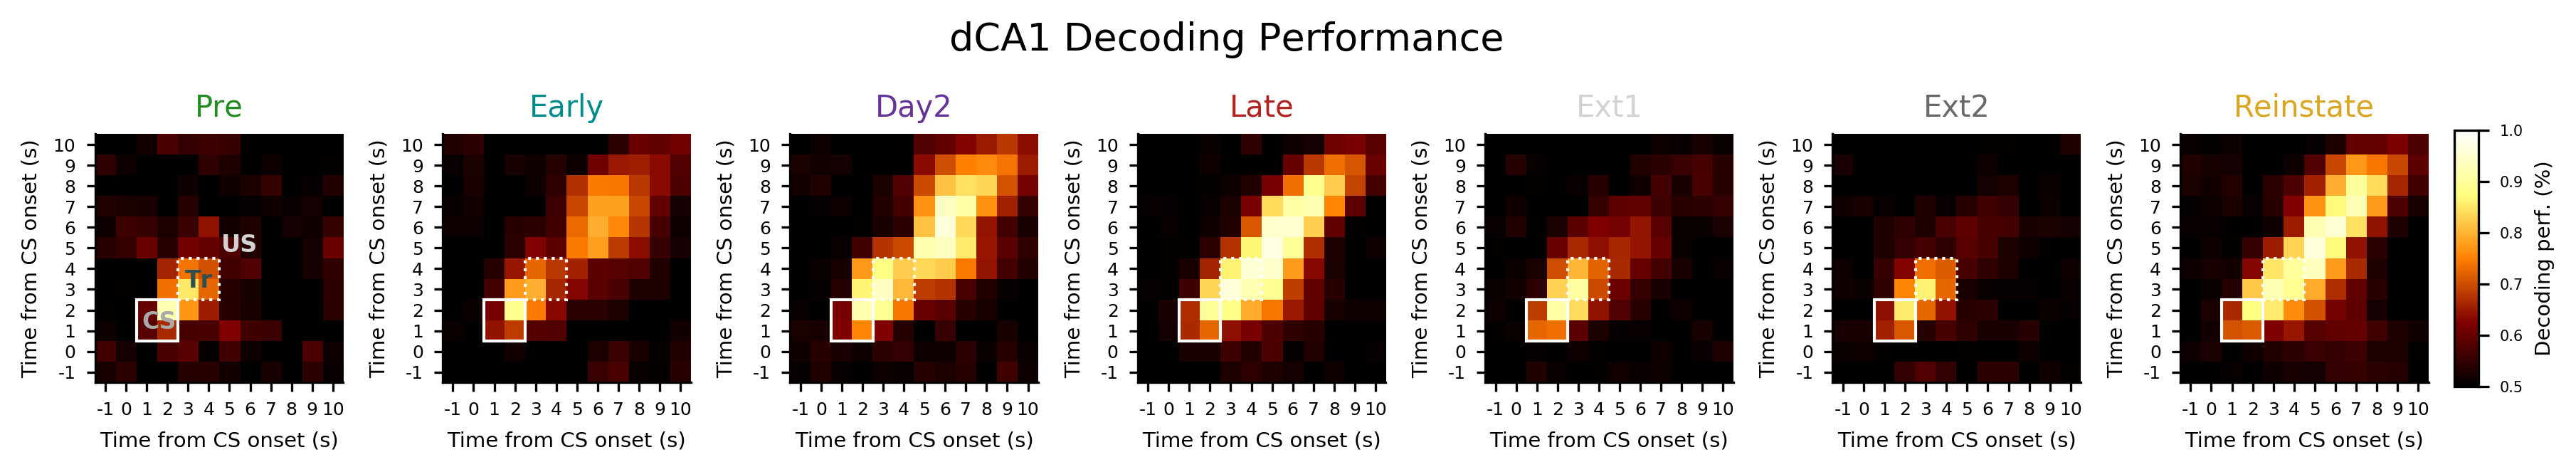

In [54]:
fig, ax = pl.subplots(1, 7, figsize=(11.5, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (0,7):
    ax[x].set_xticks(range(16))
    ax[x].set_yticks(range(16))
    ax[x].set_ylim(2.5, 14.5)
    ax[x].set_xlim(2.5,14.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(7):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='darkgray')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='darkslategray')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Decoding Performance',y=.87,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

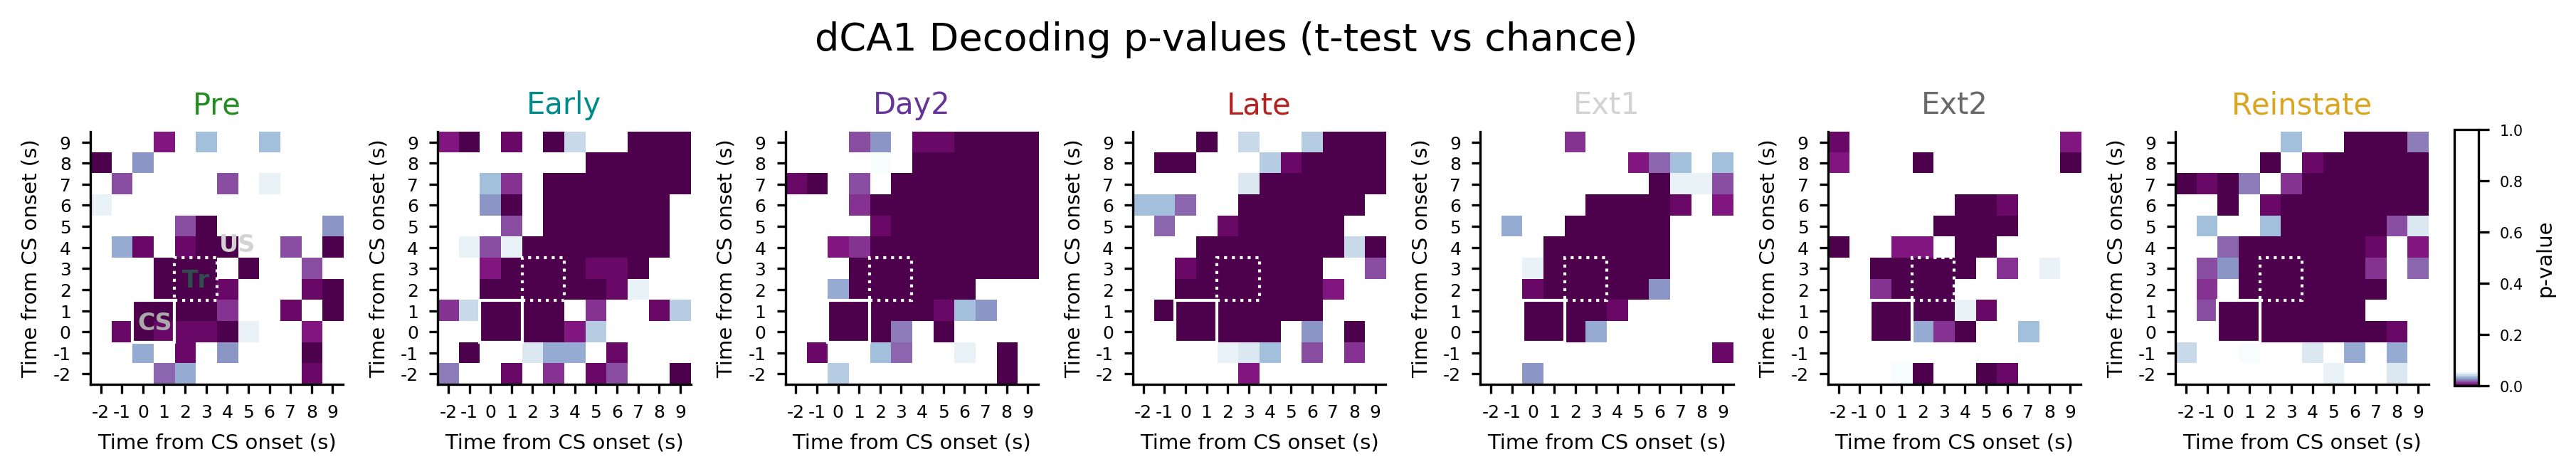

In [55]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
black = np.array([0, 0, 0, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 7, figsize=(11.5, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_ttest[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (0,7):
    ax[x].set_xticks(range(16))
    ax[x].set_yticks(range(16))
    ax[x].set_ylim(2.5, 14.5)
    ax[x].set_xlim(2.5,14.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(7):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='darkgray')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='darkslategray')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Decoding p-values (t-test vs chance)',y=.87,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='p-value')
fig.tight_layout(pad=1.5)
fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal_ttest.pdf'%NOTEBOOK_NAME)

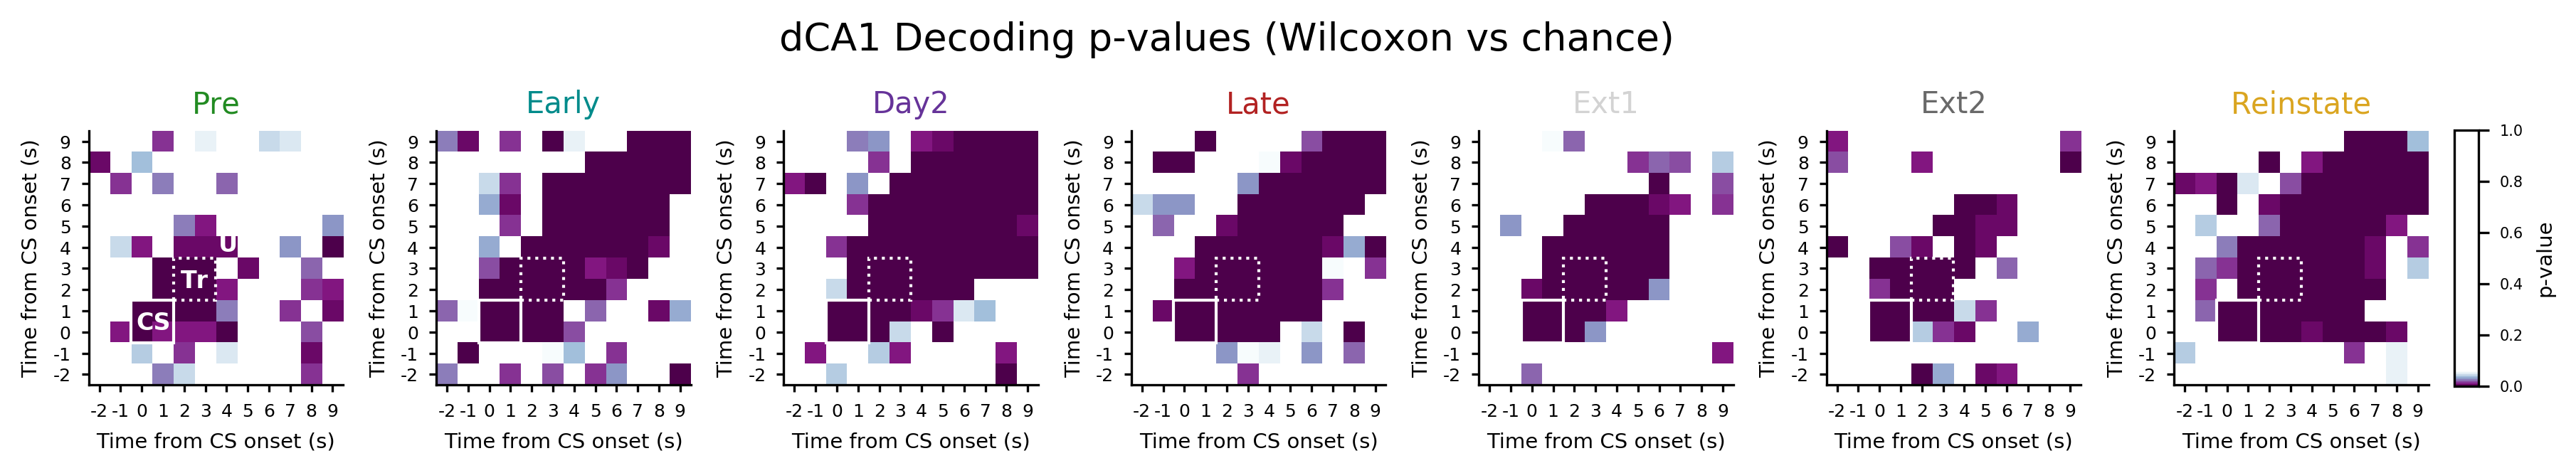

In [56]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 7, figsize=(11.5, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_wilcox[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (0,7):
    ax[x].set_xticks(range(16))
    ax[x].set_yticks(range(16))
    ax[x].set_ylim(2.5, 14.5)
    ax[x].set_xlim(2.5,14.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=2.5)

import matplotlib.patches as patches
for x in range(7):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='w')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='w')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='w')

pl.suptitle('dCA1 Decoding p-values (Wilcoxon vs chance)',y=.87,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='p-value')#,ticks=[0,.05,.1])
#cax.axes.set_ylim(0,.1)
fig.tight_layout(pad=1.5)
fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal_wilcoxon.pdf'%NOTEBOOK_NAME)

### now take mean of train/test, test/train and plot that

In [75]:
for t in range (16):
    exec('distinct_mean%s = {}'%t)
for sess in sessions:
    for t in range (16):
        exec("distinct_mean%s['%s'] = []"%(t,sess))
        for c in range (16):
            #print eval('testy%s'%t)[sess]
            eval('distinct_mean%s'%t)[sess].insert(c,(eval('scores_gmin_tb_distinct_%s_VS_%s'%(t,c))[sess].mean(1)).mean())

In [76]:
for t in range (16):
    exec('distinct_mean%s_ttest = {}'%t)
for sess in sessions:
    for t in range (16):
        exec("distinct_mean%s_ttest['%s'] = []"%(t,sess))
        for c in range (16):
            eval('distinct_mean%s_ttest'%t)[sess].insert(c,
                (sstats.ttest_1samp(eval('scores_gmin_tb_distinct_%s_VS_%s[sess].mean(1)[:15]'%(t,c)),.5)))
        for x,i in zip(eval('distinct_mean%s_ttest'%t)[sess],range(len(eval('distinct_mean%s_ttest'%t)[sess]))):
            exec("distinct_mean%s_ttest[sess][i] = x[-1]"%(t)) #only take p-values

In [77]:
for t in range (16):
    exec('distinct_mean%s_wilcox = {}'%t)
for sess in sessions:
    for t in range (16):
        exec("distinct_mean%s_wilcox['%s'] = []"%(t,sess))
        for c in range (16):
            exec("subtracted = [x-0.5 for x in scores_gmin_tb_distinct_%s_VS_%s[sess].mean(1)]"%(t,c))
            eval('distinct_mean%s_wilcox'%t)[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
        for x,i in zip(eval('distinct_mean%s_wilcox'%t)[sess],range(len(eval('distinct_mean%s_wilcox'%t)[sess]))):
            exec("distinct_mean%s_wilcox[sess][i] = x[-1]"%(t)) #only take p-values

#and now replace cross-session decoding score with within-session score where test and train data are from the same time bin
for sess in sessions:
    for t in range (16):
        eval('distinct_mean%s'%t)[sess][t] = eval("scores_gmin_tb_%s"%t)[sess].mean()

In [78]:
distinct_mean={}
for sess in sessions:
    distinct_mean[sess]=(distinct_mean0[sess], distinct_mean1[sess], distinct_mean2[sess], distinct_mean3[sess], distinct_mean4[sess], distinct_mean5[sess], distinct_mean6[sess], distinct_mean7[sess],
                 distinct_mean8[sess], distinct_mean9[sess], distinct_mean10[sess], distinct_mean11[sess], distinct_mean12[sess], distinct_mean13[sess], distinct_mean14[sess], distinct_mean15[sess])
    np.array([distinct_mean[sess]])

In [79]:
distinct_mean_ttest={}
for sess in sessions:
    distinct_mean_ttest[sess]=(distinct_mean0_ttest[sess], distinct_mean1_ttest[sess], distinct_mean2_ttest[sess], distinct_mean3_ttest[sess],
                          distinct_mean4_ttest[sess], distinct_mean5_ttest[sess], distinct_mean6_ttest[sess], distinct_mean7_ttest[sess],
                          distinct_mean8_ttest[sess], distinct_mean9_ttest[sess], distinct_mean10_ttest[sess], distinct_mean11_ttest[sess],
                          distinct_mean12_ttest[sess], distinct_mean13_ttest[sess], distinct_mean14_ttest[sess], distinct_mean15_ttest[sess])
    np.array([distinct_mean_ttest[sess]])

In [80]:
distinct_mean_wilcox={}
for sess in sessions:
    distinct_mean_wilcox[sess]=(distinct_mean0_wilcox[sess], distinct_mean1_wilcox[sess], distinct_mean2_wilcox[sess], distinct_mean3_wilcox[sess],
                          distinct_mean4_wilcox[sess], distinct_mean5_wilcox[sess], distinct_mean6_wilcox[sess], distinct_mean7_wilcox[sess],
                          distinct_mean8_wilcox[sess], distinct_mean9_wilcox[sess], distinct_mean10_wilcox[sess], distinct_mean11_wilcox[sess],
                          distinct_mean12_wilcox[sess], distinct_mean13_wilcox[sess], distinct_mean14_wilcox[sess], distinct_mean15_wilcox[sess])
    np.array([distinct_mean_wilcox[sess]])

fig, ax = pl.subplots(6, 1, figsize=(3, 15))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
im = ax[0].imshow(distinct_mean['expo'],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax)
im = ax[1].imshow(distinct_mean['pre'],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax)
im = ax[2].imshow(distinct_mean['post'],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax)
im = ax[3].imshow(distinct_mean['ext1'],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax)
im = ax[4].imshow(distinct_mean['ext2'],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax)
im = ax[5].imshow(distinct_mean['renew'],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax)

for x in range (0,6):
    ax[x].set_xticks(range(16))
    ax[x].set_yticks(range(16))
    ax[x].set_ylim(2.5, 14.5)
    ax[x].set_xlim(2.5,14.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0\n(CS)','1\n(CS)','2\n(Tr)','3\n(Tr)','4\n(Rw)','5', '6','7','8','9','10'])
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','(CS) 0','(CS) 1','(Tr) 2','(Tr) 3','(Rw) 4','5', '6','7','8','9','10'])
    ax[x].set_ylabel('Time(s) from CS onset', fontsize=5)
    ax[x].set_xlabel('Time(s) from CS onset', fontsize=5)

# axs[0].set_xticklabels(np.arange(len(np.unique(labels)))+1)
# axs[0].set_yticklabels(np.arange(len(np.unique(labels)))+1)

ax[0].set_title('vHPC Decoding Across Time Bin\nExpo', fontsize=7, color='limegreen')
ax[1].set_title('Pre', fontsize=7, color='b')
ax[2].set_title('Post', fontsize=7, color='r')
ax[3].set_title('Ext1', fontsize=7, color='silver')
ax[4].set_title('Ext2', fontsize=7, color='grey')
ax[5].set_title('Reinstate', fontsize=7, color='y')

cax = fig.add_axes([.83, 0.854, 0.05, 0.117])
fig.colorbar(im, cax=cax)
fig.tight_layout(pad=2.5)
fig.savefig('../img/%s_gmin_across_bins_distinct_mean.jpg'%NOTEBOOK_NAME)

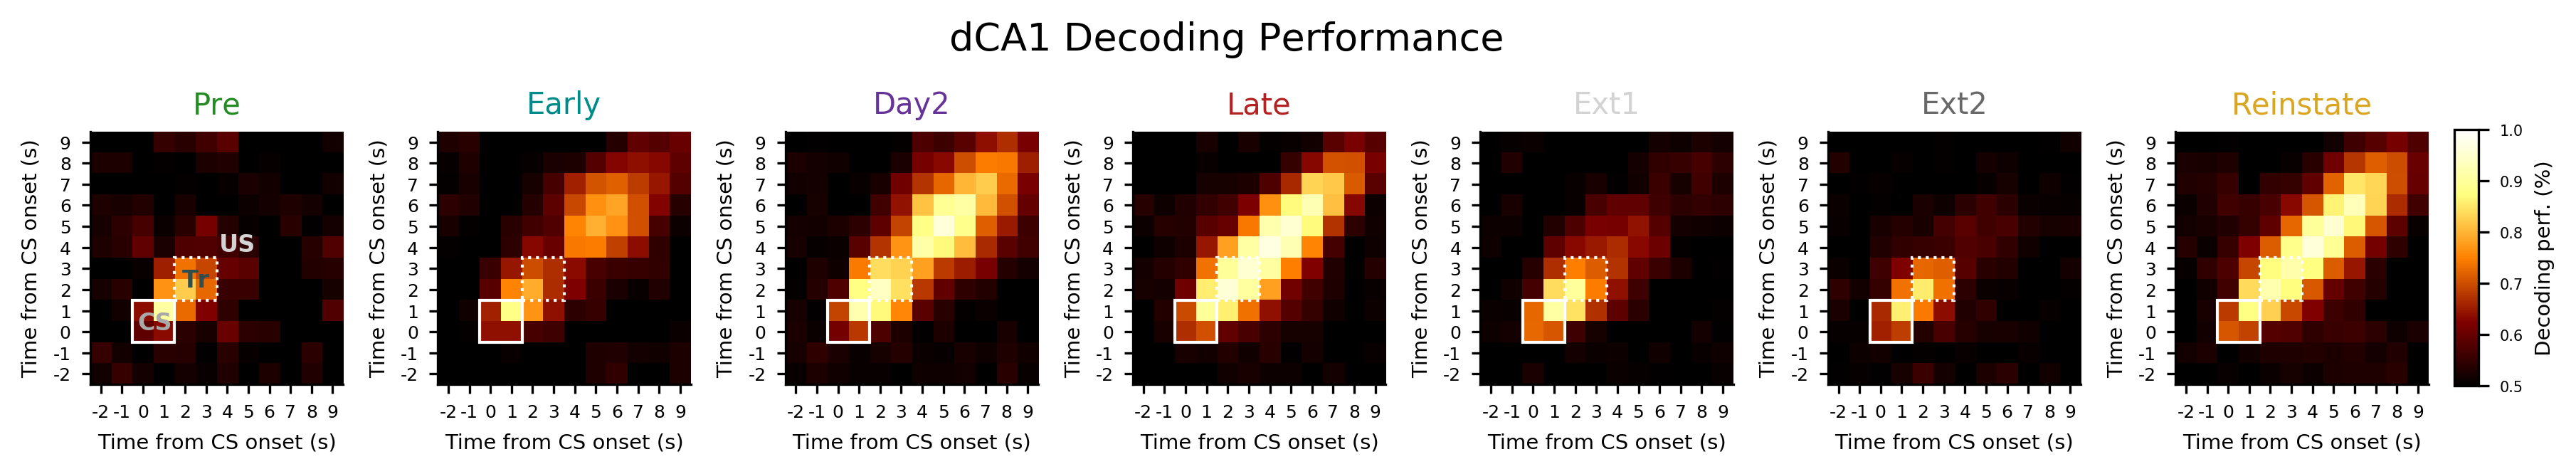

In [81]:
fig, ax = pl.subplots(1, 7, figsize=(11.5, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_mean[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (0,7):
    ax[x].set_xticks(range(16))
    ax[x].set_yticks(range(16))
    ax[x].set_ylim(2.5, 14.5)
    ax[x].set_xlim(2.5,14.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(7):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='darkgray')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='darkslategray')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Decoding Performance',y=.87,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
fig.savefig('../img/%s_gmin_across_bins_distinct_mean_horizontal.pdf'%NOTEBOOK_NAME)

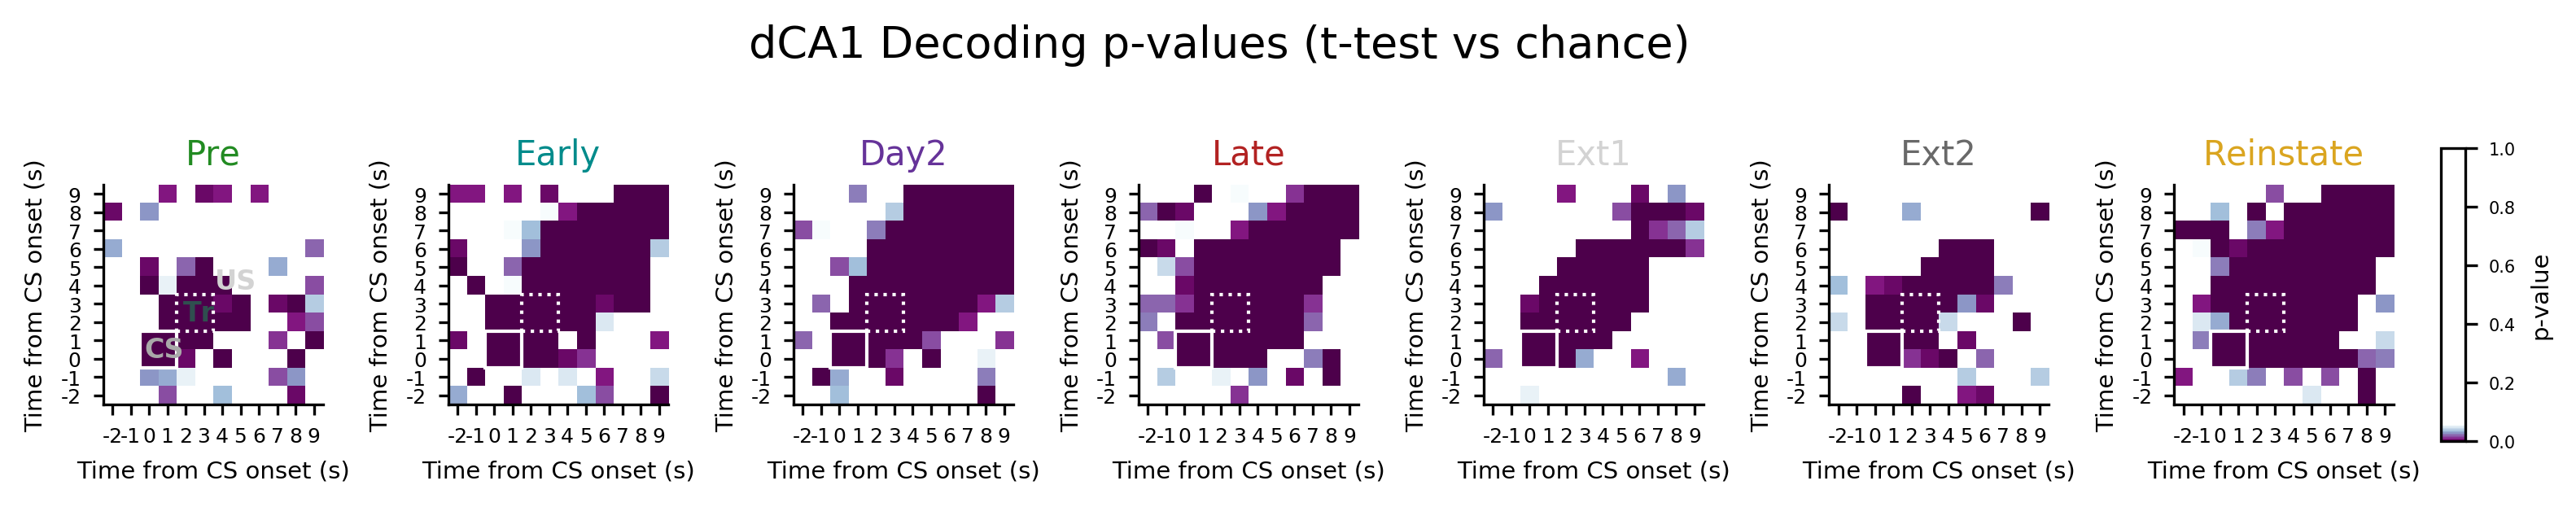

In [82]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
black = np.array([0, 0, 0, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 7, figsize=(10, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_mean_ttest[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (0,7):
    ax[x].set_xticks(range(16))
    ax[x].set_yticks(range(16))
    ax[x].set_ylim(2.5, 14.5)
    ax[x].set_xlim(2.5,14.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(7):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='darkgray')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='darkslategray')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Decoding p-values (t-test vs chance)',y=.87,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='p-value')
fig.tight_layout(pad=1.5)
fig.savefig('../img/%s_gmin_across_bins_distinct_mean_horizontal_ttest.pdf'%NOTEBOOK_NAME)

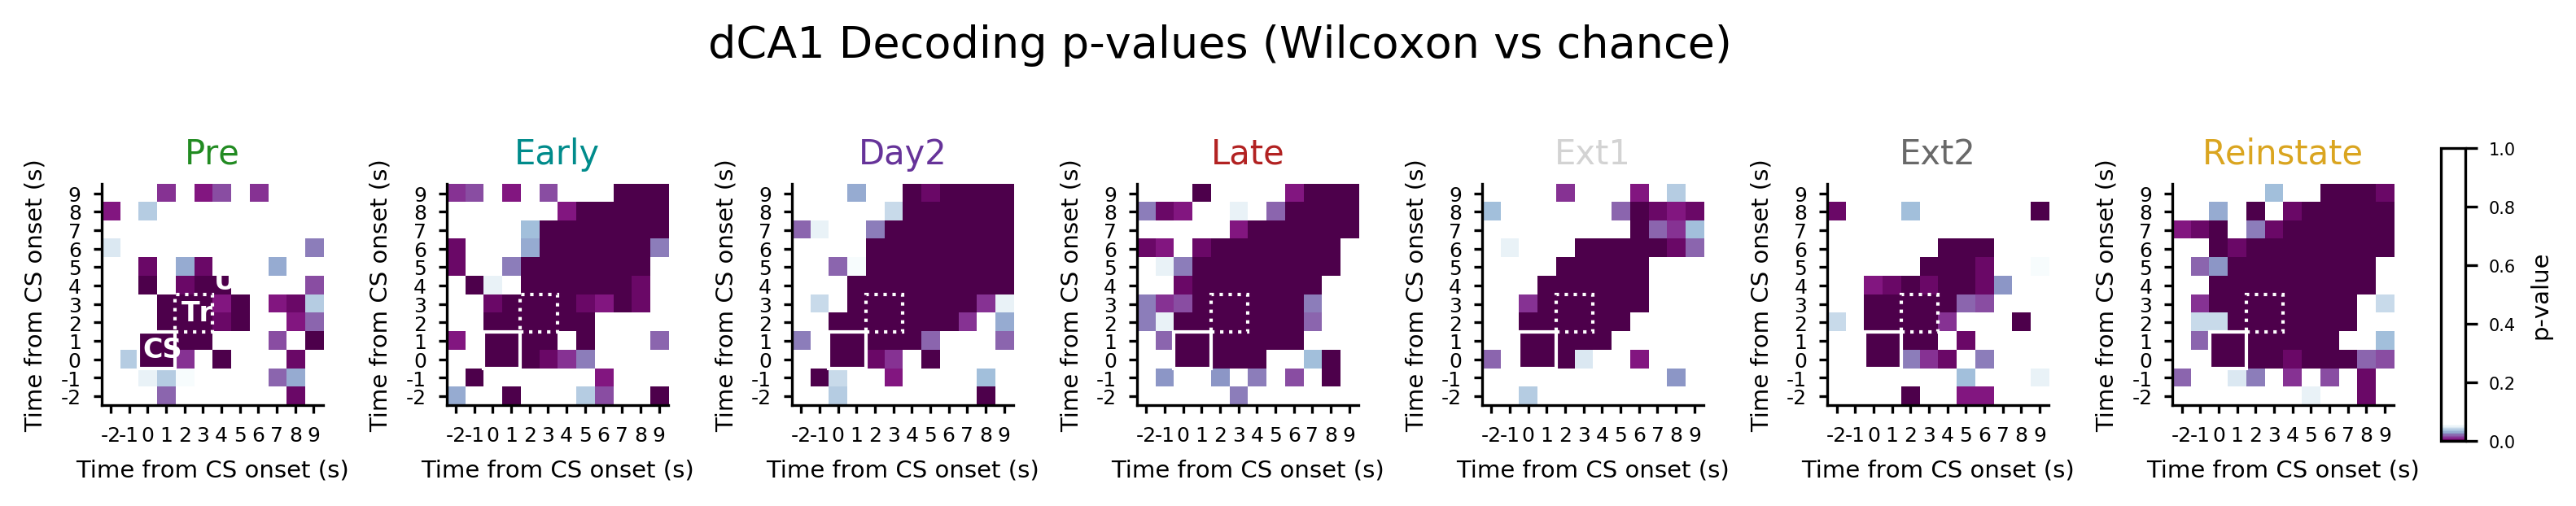

In [85]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 7, figsize=(10, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_mean_wilcox[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (0,7):
    ax[x].set_xticks(range(16))
    ax[x].set_yticks(range(16))
    ax[x].set_ylim(2.5, 14.5)
    ax[x].set_xlim(2.5,14.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=2.5)

import matplotlib.patches as patches
for x in range(7):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='w')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='w')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='w')

pl.suptitle('dCA1 Decoding p-values (Wilcoxon vs chance)',y=.87,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='p-value')#,ticks=[0,.05,.1])
#cax.axes.set_ylim(0,.1)
fig.tight_layout(pad=1.5)
fig.savefig('../img/%s_gmin_across_bins_distinct_mean_horizontal_wilcoxon.pdf'%NOTEBOOK_NAME)

In [86]:
save_workspace(db)

Could not store variable 'IPython'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'np'. Skipping...
